# AI Project A*

Trabalho realizado por:
 - Tiago Matos 21905643
 - Paulo Pinto 21906966

A estrutura necessária para executar este notebook é a seguinte:
```
├── input
│   └── sample-environment.csv
├── output
├── solves
└── Projeto.ipynb
```

### Imports

| Library      | Descrição |
| ----------- | ----------- |
| matplotlib, seaborn      | desenhar gráficos e heatmap       |
| imageio   | criar gif da solução        |
| pandas   | dataframe para representar dados em gráficos        |
| numpy   | array para guardar o mapa        |
| shutil, os   | gestão de ficheiros e directories (apagar `/output/`)        |
| time   | obter a unix timestamp. medir perfomance de funções        |
| math   | operações matemáticas como floor() ou sqrt()        |

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v2 as imageio

import pandas as pd
import numpy as np

import shutil
import os

import time
import math

plt.ioff()

### Tipos de Nós

In [2]:
START = 'S'  # Start -> nó inicial (canto superior esquerdo)
END = 'E'  # End -> nó final (canto inferior direito)
TERRA = 'T'  # Terra -> movimento para este nó tem custo 1
AGUA = 'A'  # Agua -> movimento para este nó tem custo 3
BARREIRA = 'B'  # Barreira -> can't move here
FRONTEIRA = 'F'  # Fronteira -> can't move here


### Classe Node

A classe Node serve para guardar as informações dos vários elementos do mapa. Tem variáveis como a posição, o melhor caminho até à casa e o seu custo.

O atributo `combined_cost` usa o decorator `@property`, que funciona como getter e setter

In [3]:
class Node:
    def __init__(self, name, pos, cost_so_far, heuristic, path):
        self.name = name
        self.pos = pos
        self.cost_so_far = cost_so_far
        self.heuristic = heuristic
        self.path = path
        self.visited = False
        self.done = False
    
    def __str__(self):
        return f'{self.name} | {self.pos} | {self.cost_so_far} | {self.heuristic} | {self.combined_cost}\n{self.path}'
    
    def __eq__(self, obj):
        return obj.name == self.name and obj.pos == self.pos
    
    @property
    def combined_cost(self):
        return self.cost_so_far + self.heuristic

### Visualização

`get_graph_map_list` cria a grid e substitui as posições visitadas, feitas e que pertencem ao caminho final

`visualize_env` usa a biblioteca seaborn para mostrar o estado atual do mapa, incluindo o caminho

`print_path_with_cost` mostra o caminho com e o custo (`cost_so_far`) ao longo do mesmo numa lista

`vizualize_final_path` mostra o caminho que for introduzido, é usado para mostrar o caminho no final

`create_gif` gera um gif com várias fases dá execução do algoritmo

In [4]:
def get_graph_map_list(node_map, path=[], show_visited=True):
    map = [[''] * (MAP_SIZE + 1) for _ in range(MAP_SIZE + 1)]
    for x, y in node_map:
        if (x, y) in path:
            map[x][y] = "SP"
        elif node_map[(x, y)].done and show_visited:
            map[x][y] = "D"
        elif node_map[(x, y)].visited and show_visited:
            map[x][y] = "V"
        else:
            map[x][y] = node_map[(x, y)].name
    map[MAP_SIZE][MAP_SIZE] = 'E'
    return map

def visualize_env(map, file_name):
    map_envir = pd.DataFrame(map)
    map_env_num = map_envir.replace(['T', 'A', 'F', 'B', 'S', 'E', 'V', 'D', 'SP'], [
                                      2,   3,   0,   0,   1,   1,   4,   5,   6])
    f, ax = plt.subplots(figsize=(16, 10))
    # hide labels, force square cells
    ax = sns.heatmap(map_env_num, cmap="mako", yticklabels=False, xticklabels=False, cbar=False, square=True)
    f.savefig(f'output/{file_name}.png')

def print_path_with_cost(node_map, path):
    print('Path:')
    for (i, (x, y)) in enumerate(path):
        print(f"{i: >3} -> ({x:>2} , {y:>2}) : {node_map[(x,y)].cost_so_far:>3}")

def vizualize_final_path(node_map, pos):
    path = node_map[pos].path
    cost = node_map[pos].cost_so_far
    
    grid = get_graph_map_list(node_map, path=path, show_visited=False)
    
    print_path_with_cost(node_map, path)
    
    print(f"final path's length is {len(path)} - costs {cost}")
    visualize_env(grid, 'final_path')

In [5]:
def create_gif():
    images = []

    dir = os.listdir("output")

    for filename in dir:
        f = os.getcwd() + "\\output\\" + filename
        # don't show path
        if "path.png" in f:
            continue
        # show final map for longer
        if "map_stage_final.png" in f:
            for _ in range(20):
                images.append(imageio.imread(f))

        images.append(imageio.imread(f))

    if images:
        imageio.mimsave(os.getcwd() + "\\solves\\solve.gif", images, duration=0.15)
    else:
        print("No images were generated, can't create gif")

### Leitura do Ficheiro

In [6]:
def read_file(file_name):
    """Retorna um array (formatado) com os dados do ficheiro escolhido"""
    with open(file_name) as fp:
        fp.readline() # skip first line
        for l in fp.readlines():
            yield l.strip("\n").split(',')[1:]

### Cálculo Heurística

Considerámos 4 formas diferentes de calcular a heurística, baseadas em fórmulas que encontrámos online. Acabámos por optar pela distância *octile* visto que foi a que - dentro das que encontraram o caminho com menos custo - foi a que encontrou a solução de forma mais rápida.

Entendemos que esta fórmula assume que o custo do movimento diagonal é √2 em vez de 1, mas o resultado obtido é o mesmo, visto que é apenas a fórmula de calcular o custo de heurística. Experimentámos outra versão desta fórmula, assumindo o custo do movimento diagonal como 2 e esta versão é a que produz o resultado mais rapidamente e de forma mais elegante mas, infelizmente, não encontra a melhor solução (custo de 170 em vez de 165).

**Os custos do caminho englobam o movimento para a última casa, resultado num custo de 165 em vez de 164.**

Fonte : http://theory.stanford.edu/~amitp/GameProgramming/Heuristics.html#diagonal-distance

In [7]:
# 165
def calculate_heuristic_distance_basic(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    return max(dx, dy)

# 165
def calculate_heuristic_distance_euclidean(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    return 1 * math.sqrt(dx * dx + dy * dy)

# 165
def calculate_heuristic_distance_octile_sqrt(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    md = 1 # move distance - horizontal and vertical
    md2 = math.sqrt(2) # move distance 2 - diagonal
    return md * (dx + dy) + (md2 - 2 * md) * min(dx, dy)

# 170 - mais rápido e mais elegante, mas tem um custo mais elevado
def calculate_heuristic_distance_octile(x,y, final_x, final_y):
    dx = abs(x - final_x)
    dy = abs(y - final_y)
    md = 1 # move distance - horizontal and vertical
    md2 = 2 # move distance 2 - diagonal
    return md * (dx + dy) + (md2 - 2 * md) * min(dx, dy)

### Calcular próximos movimentos

In [8]:
def get_next_moves(x, y):
    return [
        (x - 1, y - 1),
        (x - 1, y),
        (x - 1, y + 1),
        (x, y - 1),
        (x, y + 1),
        (x + 1, y - 1),
        (x + 1, y),
        (x + 1, y + 1),
    ]

## A*

Esta solução usa o método iterativo, fazendo *loop* dentro dum while até encontrar o final, providenciado pelo parâmetro `goal`.

Optámos por criar classes para os nós e implementar o atributo `done` na classe `Node`, deixando de necessitar da lista de nós feitos.

In [9]:
def a_star_algo(counter, q, node_map, goal):
    while q:
        counter += 1
        if counter % DISPLAY_INTERVAL == 0 and VISUALIZE:
            visualize_env(get_graph_map_list(node_map), 
                    f"map_stage_{int(counter / DISPLAY_INTERVAL):0>2}",)

        h = q.pop(0)
        node_map[h].done = True

        if VERBOSE:
            print("HEAD -> ", node_map[h])
            print('q = [', end='')
            for (i, n) in enumerate(q):
                print(f'{node_map[n].pos} [{node_map[n].cost_so_far} + {node_map[n].heuristic} = {node_map[n].combined_cost}]', end=(', ' if i != len(q) - 1 else ']\n'))

        if h == goal:
            visualize_env(get_graph_map_list(node_map,node_map[h].path), 'map_stage_final')
            vizualize_final_path(node_map, h)
            return
        
        for x, y in get_next_moves(*h):
            # if move goes outside of map, skip
            if not 0 < x <= MAP_SIZE or not 0 < y <= MAP_SIZE:
                continue

            node = node_map[(x,y)]
            
            if VERBOSE: print(f'{node.pos} move -> {node.name not in [FRONTEIRA, BARREIRA] and not node.done}')
            
            if node.name not in [FRONTEIRA, BARREIRA] and not node.done:
                # check cost of valid nodes
                if VERBOSE: print(f'{node.name} {node.pos}: {node.cost_so_far} + {node.heuristic} = {node.combined_cost} -> ', end='')
                if node.cost_so_far > (new_cost := node_map[h].cost_so_far + (3 if node.name == AGUA else 1)):
                    # change cost and path if new path is better
                    node.cost_so_far = new_cost
                    node.path = node_map[h].path + [node.pos]
                if not node.visited:
                    q.append(node.pos)
                    node.visited = True

        q = list(set(q)) # remove duplicates
        q.sort(key=lambda x: node_map[x].combined_cost)
        # a_star_algo(counter, q, node_map, goal)

### Versão Simplificada

Sem prints, counter ou comments

In [10]:
def a_star_algo_simplified(q, node_map, goal):
    while q:
        h = q.pop(0)
        node_map[h].done = True

        if h == goal:
            print('Got to the END!')
            print(f'Cost at the END: {node_map[h].cost_so_far}')
            return
        
        for x, y in get_next_moves(*h):
            if not 0 < x <= MAP_SIZE or not 0 < y <= MAP_SIZE:
                continue

            node = node_map[(x,y)]

            if node.name not in [FRONTEIRA, BARREIRA] and not node.done:
                if node.cost_so_far > (new_cost := node_map[h].cost_so_far + (3 if node.name == AGUA else 1)):
                    node.cost_so_far = new_cost
                    node.path = node_map[h].path + [node.pos]
                if not node.visited:
                    q.append(node.pos)
                    node.visited = True

        q = list(set(q)) # remove duplicates
        q.sort(key=lambda x: node_map[x].combined_cost)

Escolher Parâmetros de Execução

In [11]:
CSV_ENV_FILE = "input/sample-environment.csv"
VISUALIZE = True
VERBOSE = False
DISPLAY_INTERVAL = 25 # 25

Inicialização dos dados necessários para correr o algoritmo `A*` e execução

C:\Users\ppdig\AppData\Local\Temp\ipykernel_9272\421426596.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(16, 10))


Path:
  0 -> ( 0 ,  0) :   0
  1 -> ( 1 ,  1) :   1
  2 -> ( 2 ,  2) :   2
  3 -> ( 3 ,  3) :   3
  4 -> ( 4 ,  4) :   4
  5 -> ( 5 ,  5) :   5
  6 -> ( 6 ,  6) :   6
  7 -> ( 7 ,  6) :   7
  8 -> ( 8 ,  6) :   8
  9 -> ( 9 ,  6) :   9
 10 -> (10 ,  6) :  10
 11 -> (11 ,  6) :  11
 12 -> (12 ,  7) :  12
 13 -> (13 ,  8) :  13
 14 -> (14 ,  9) :  14
 15 -> (15 , 10) :  15
 16 -> (16 , 11) :  16
 17 -> (17 , 12) :  17
 18 -> (18 , 12) :  18
 19 -> (19 , 12) :  19
 20 -> (20 , 12) :  20
 21 -> (21 , 13) :  21
 22 -> (22 , 14) :  22
 23 -> (23 , 15) :  23
 24 -> (24 , 16) :  24
 25 -> (25 , 17) :  25
 26 -> (24 , 18) :  26
 27 -> (23 , 19) :  27
 28 -> (22 , 20) :  28
 29 -> (22 , 21) :  29
 30 -> (21 , 22) :  30
 31 -> (20 , 23) :  31
 32 -> (19 , 24) :  32
 33 -> (19 , 25) :  33
 34 -> (19 , 26) :  34
 35 -> (20 , 27) :  35
 36 -> (21 , 28) :  36
 37 -> (22 , 29) :  37
 38 -> (23 , 30) :  38
 39 -> (24 , 31) :  39
 40 -> (24 , 32) :  40
 41 -> (25 , 33) :  43
 42 -> (26 , 34) :  46
 43 -

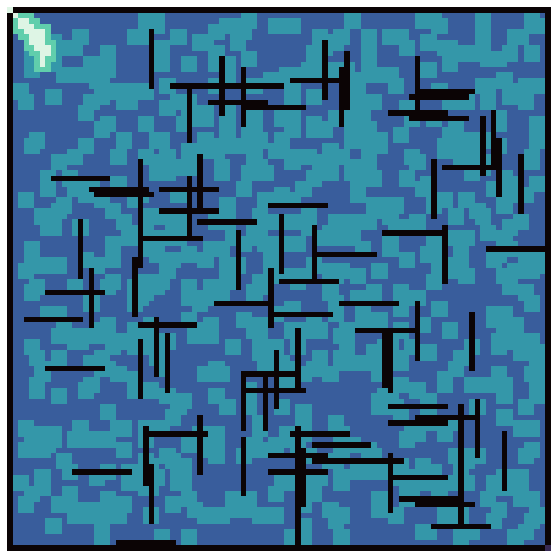

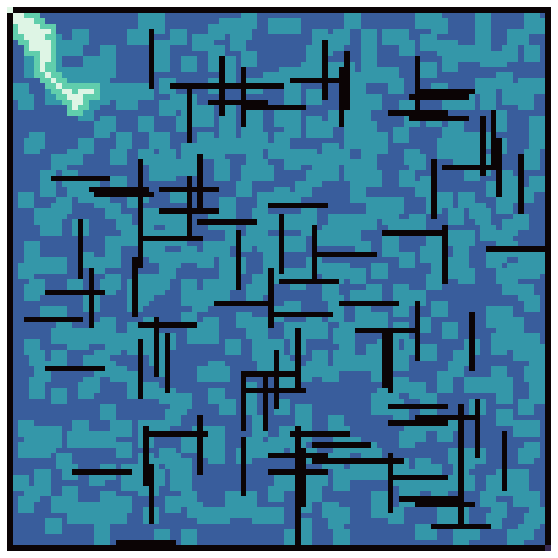

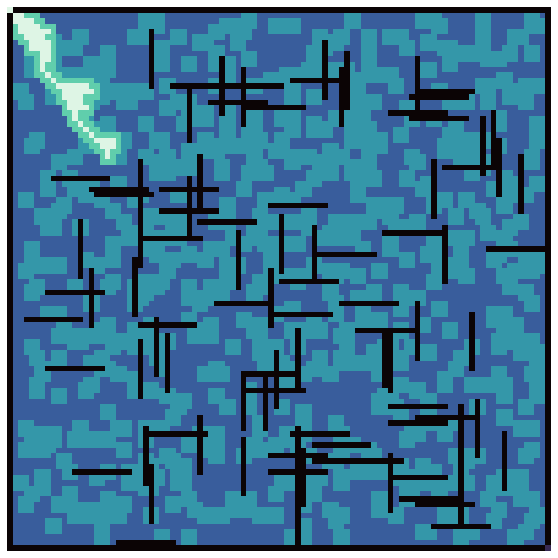

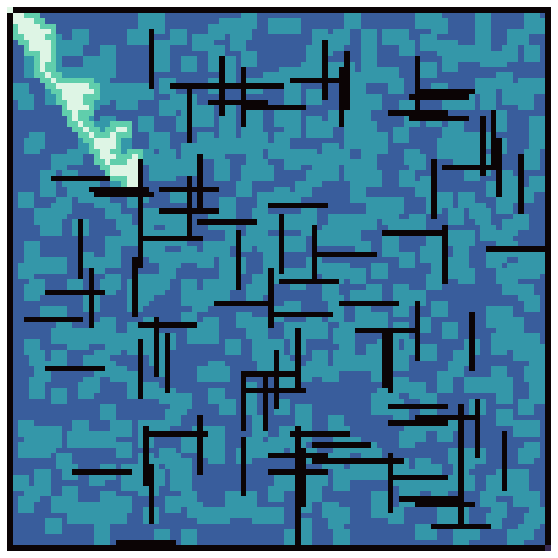

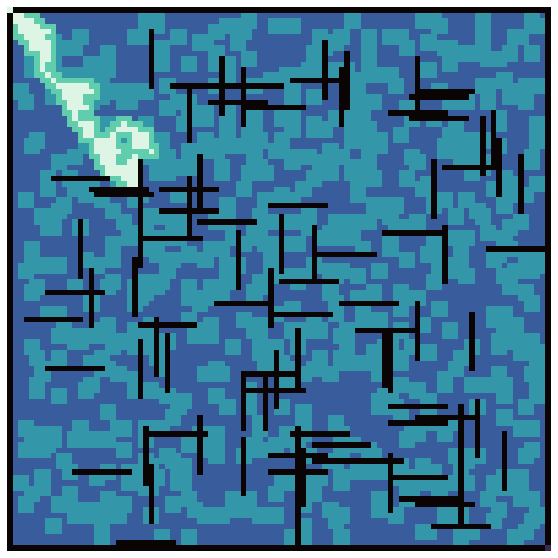

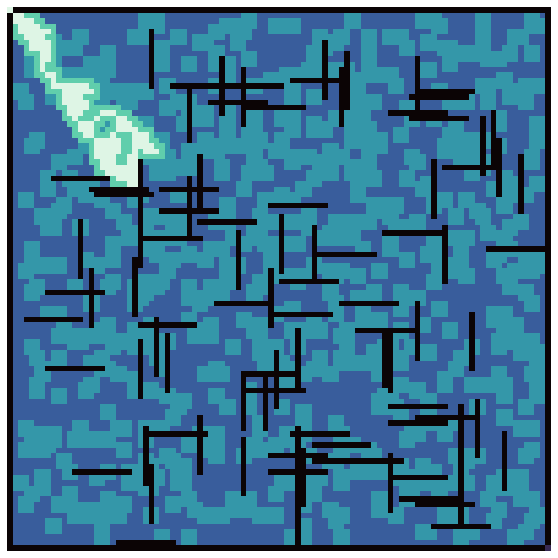

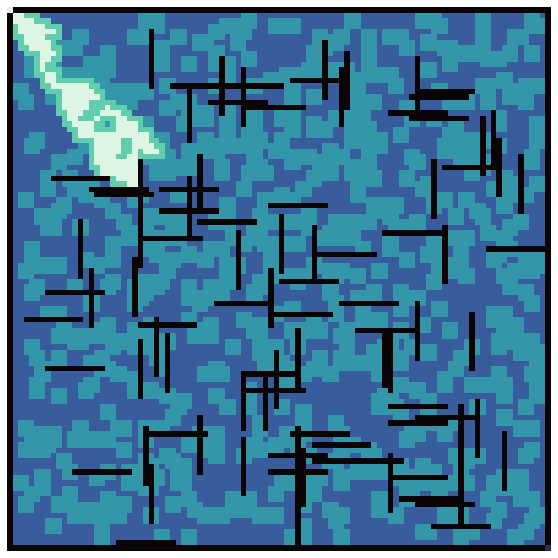

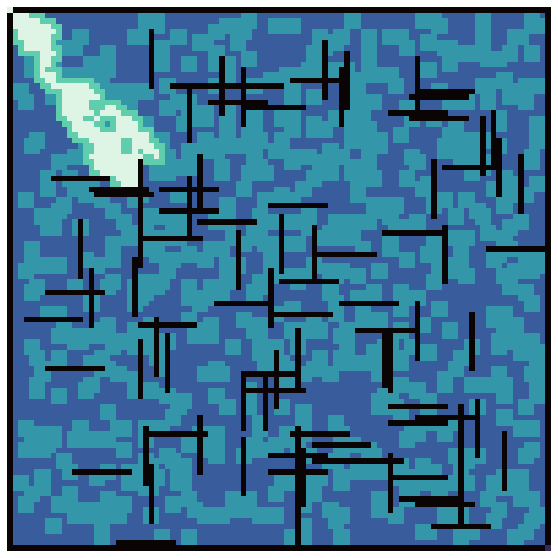

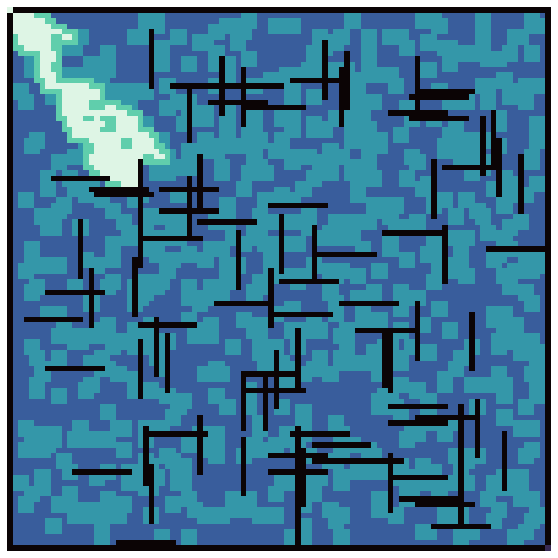

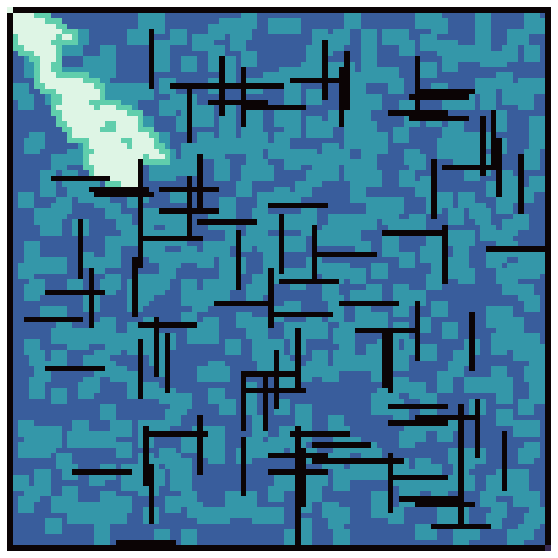

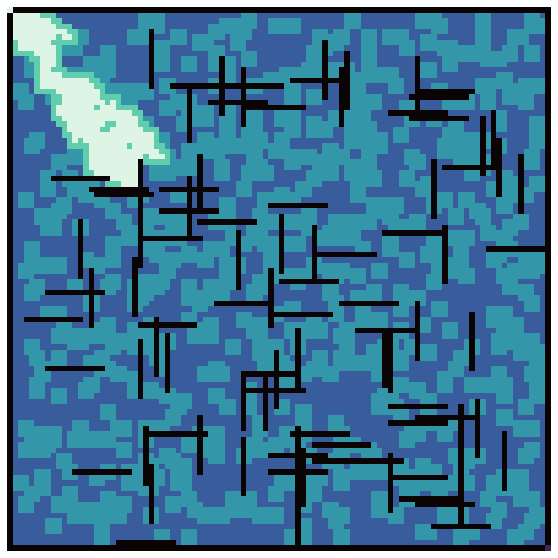

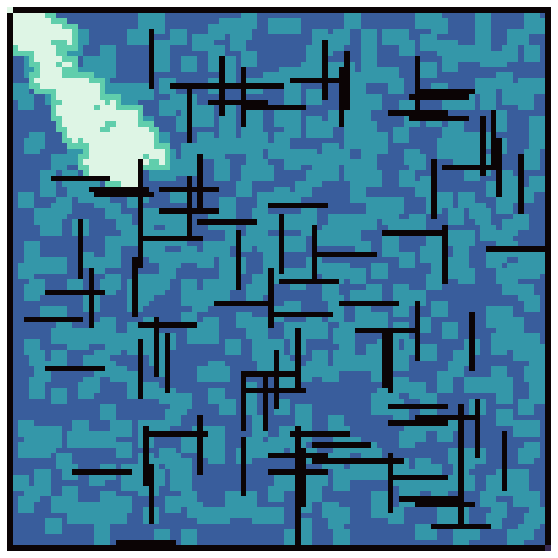

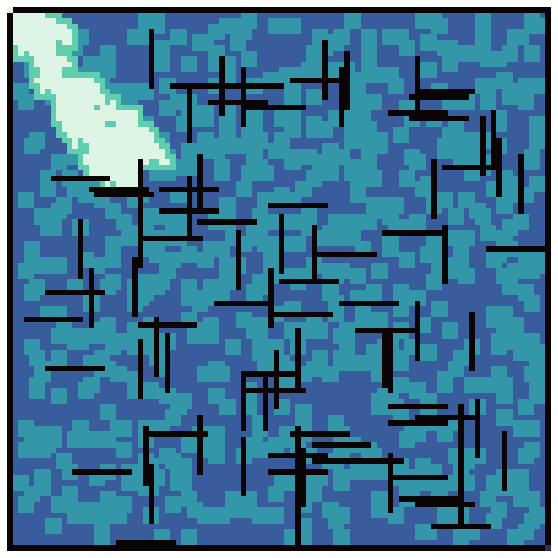

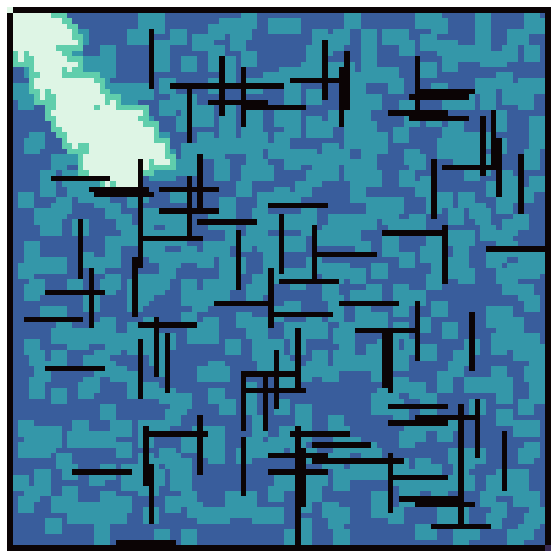

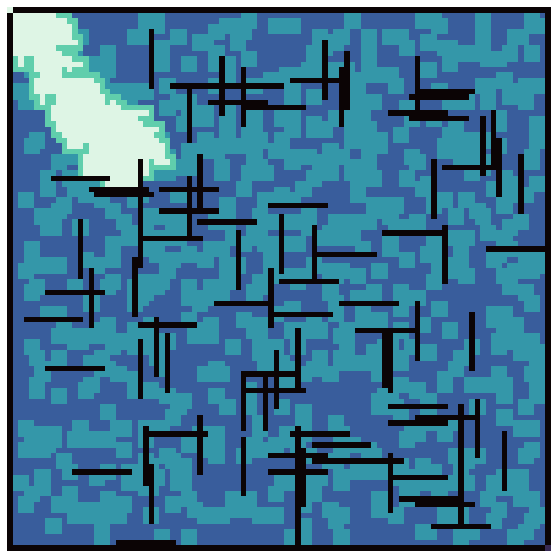

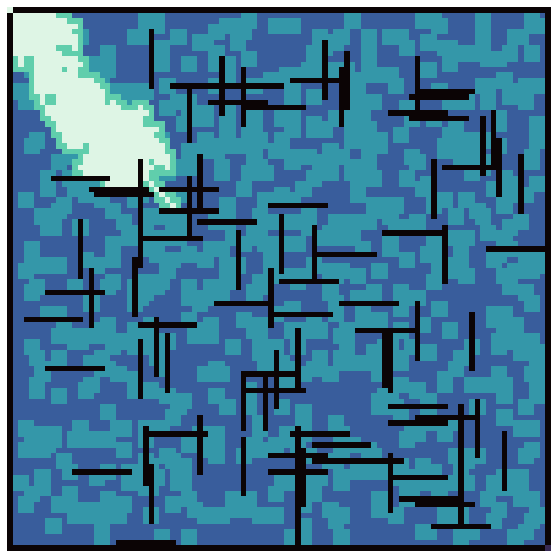

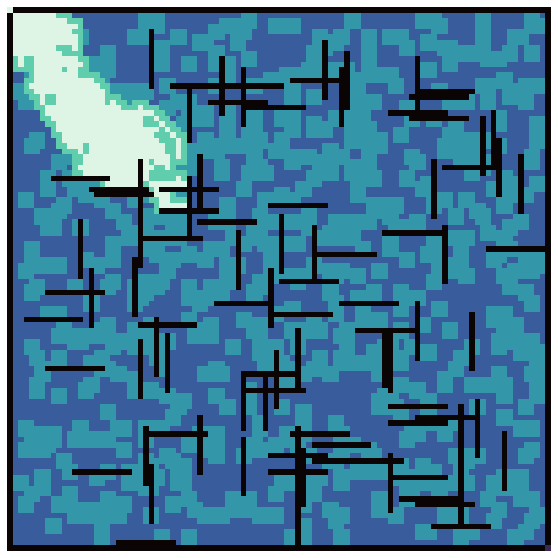

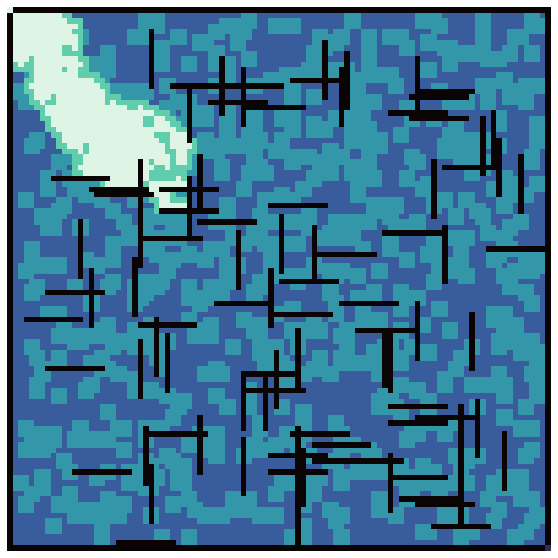

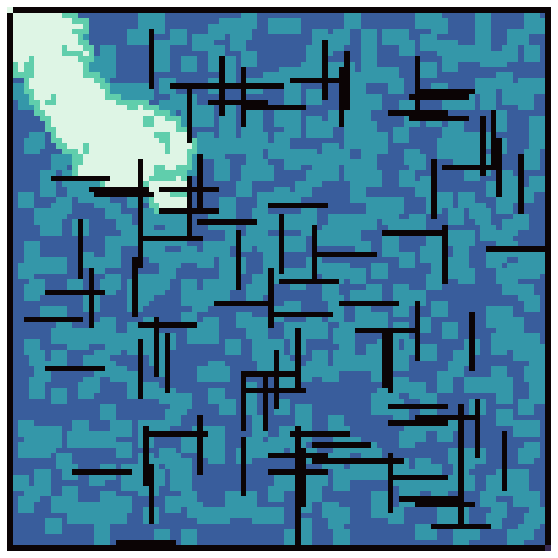

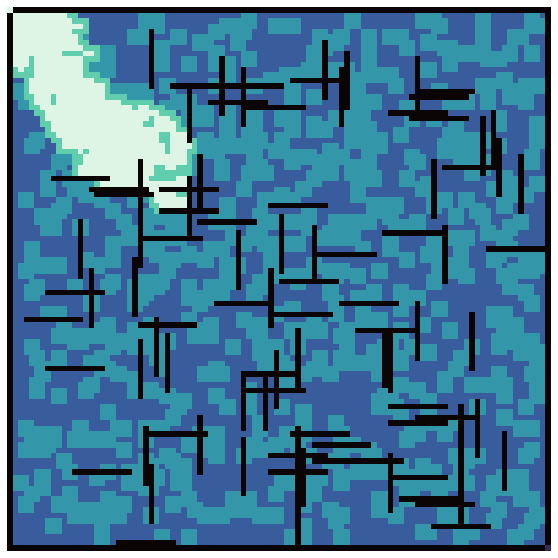

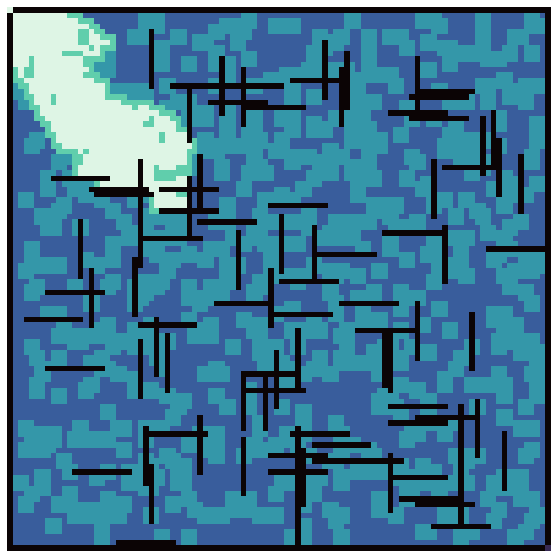

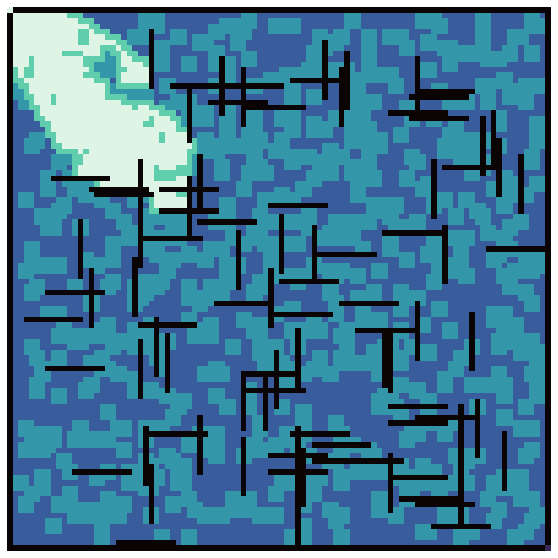

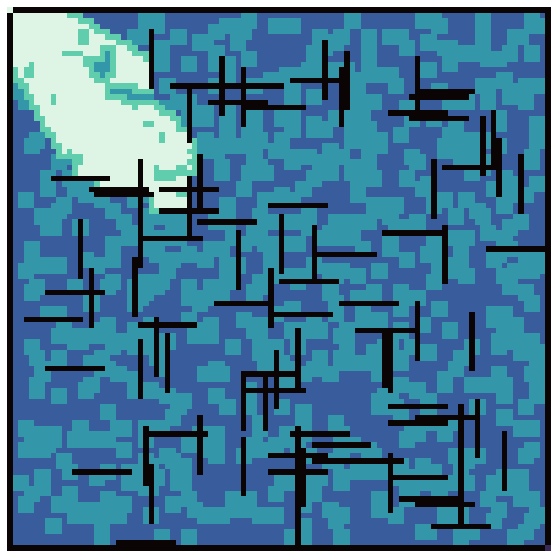

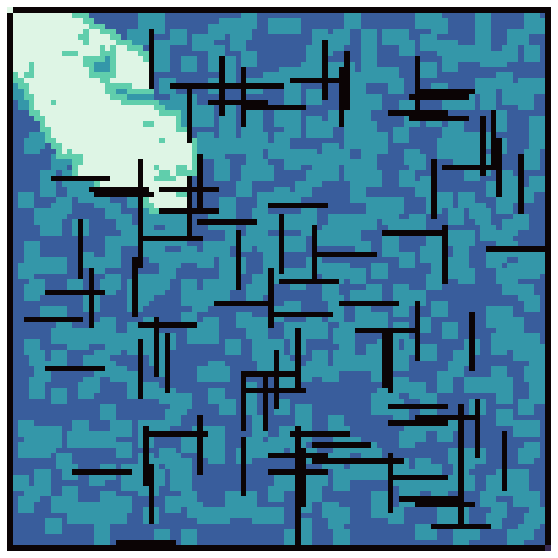

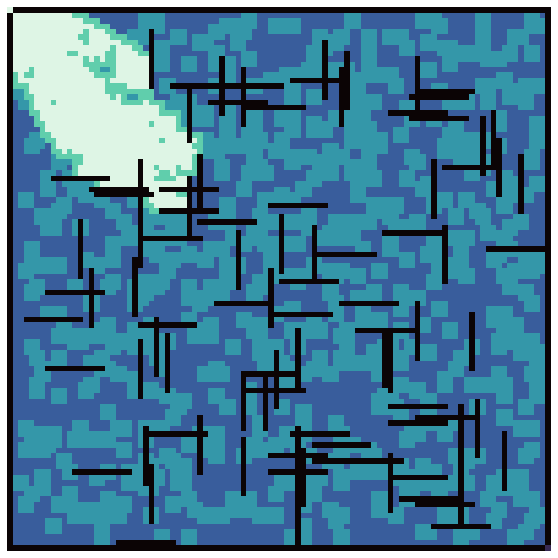

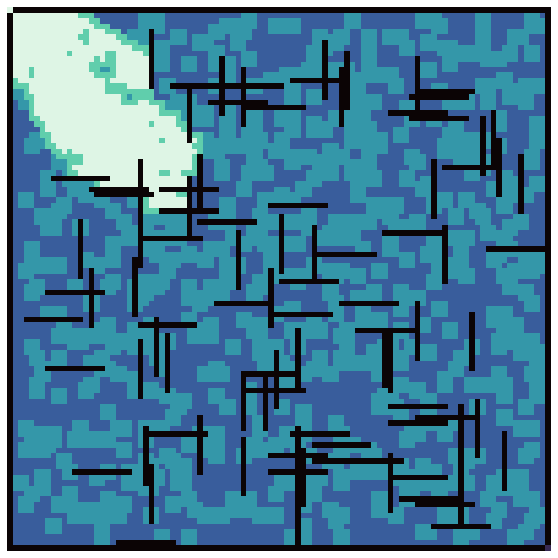

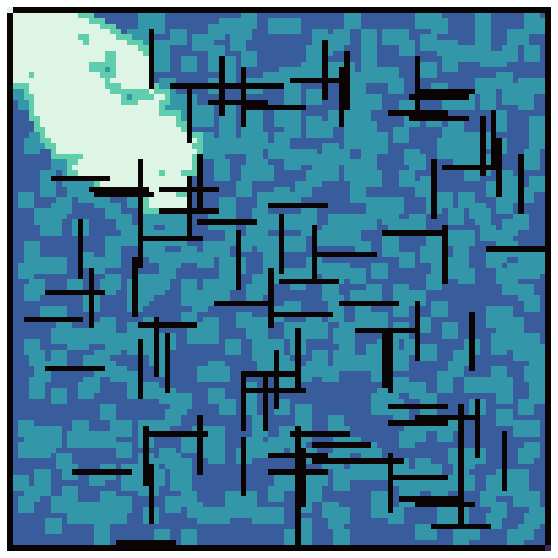

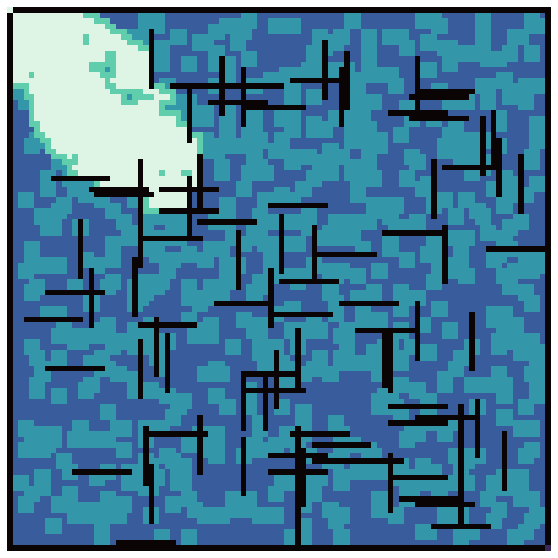

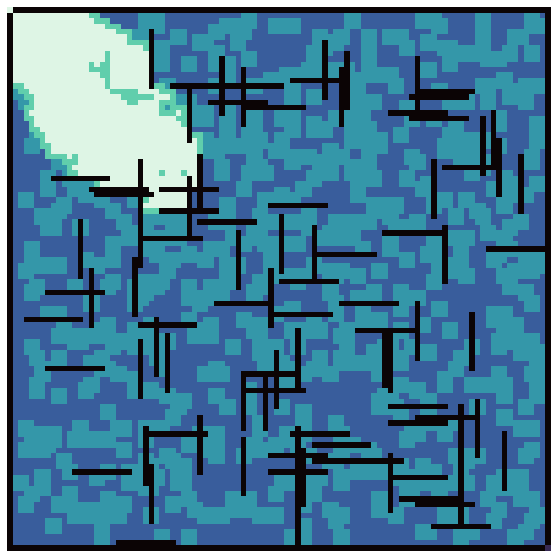

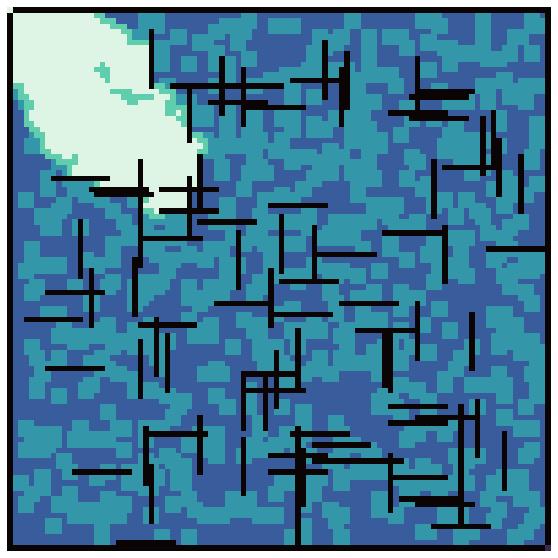

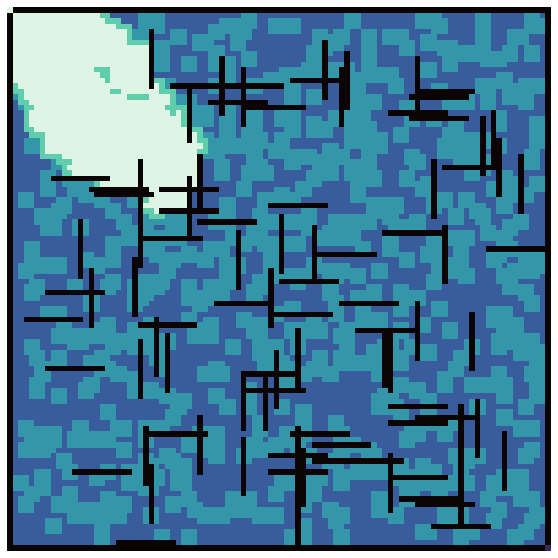

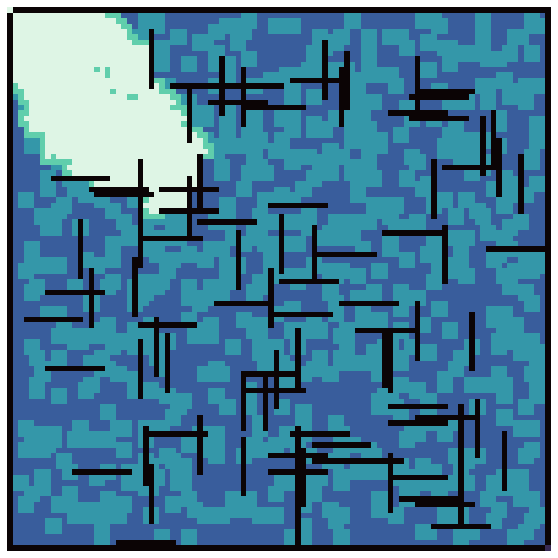

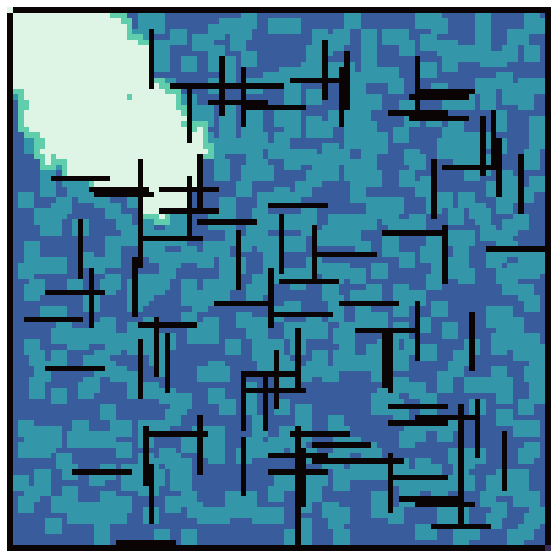

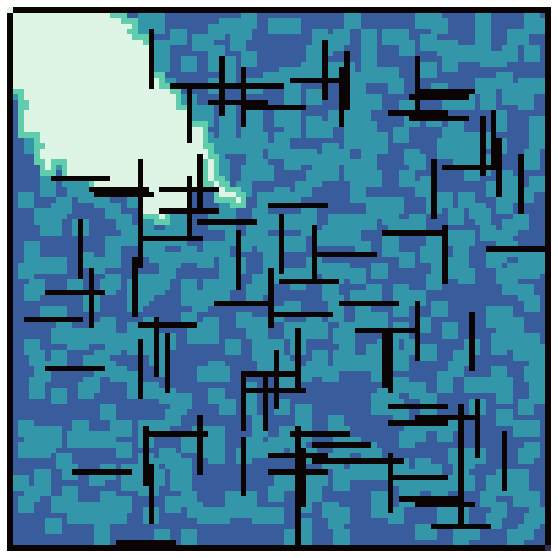

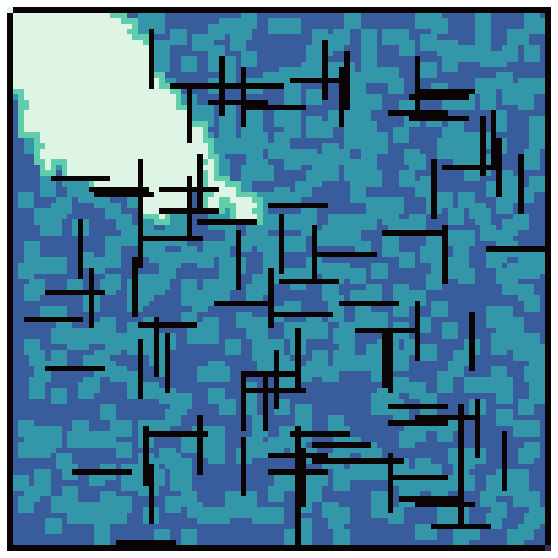

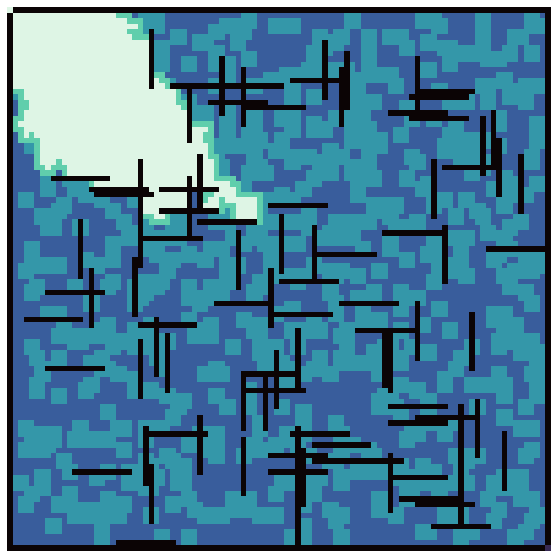

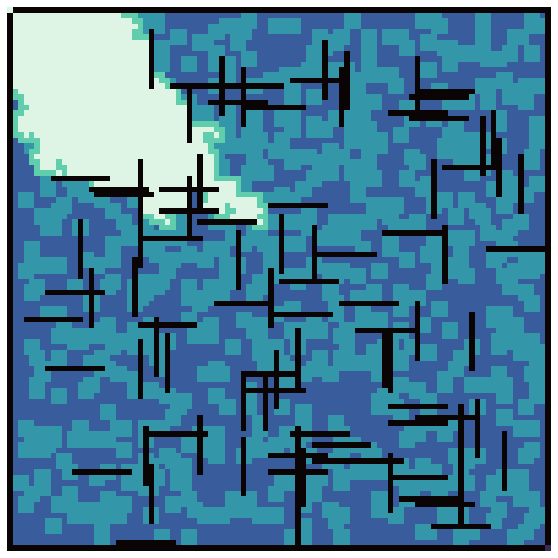

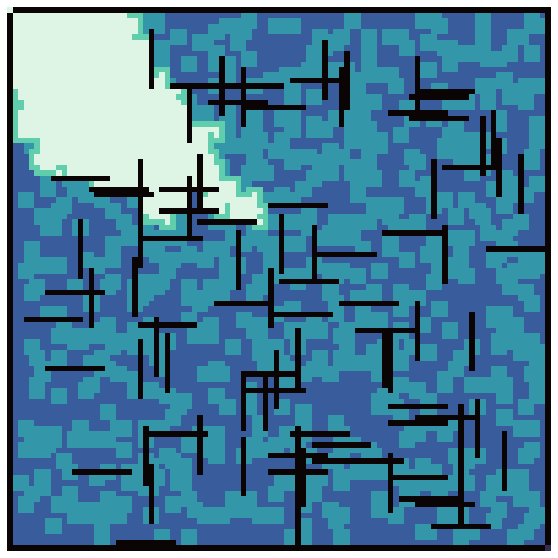

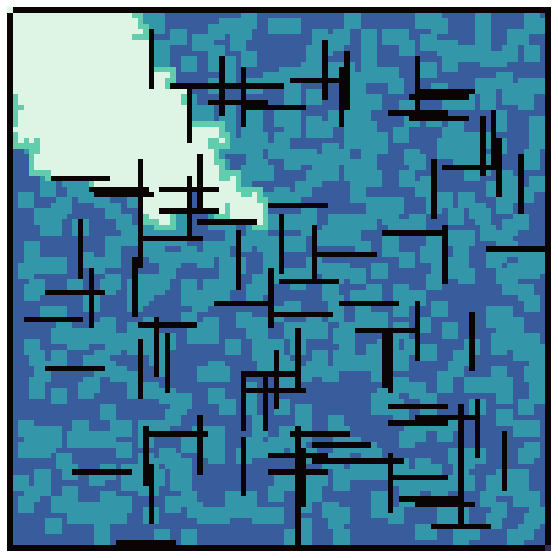

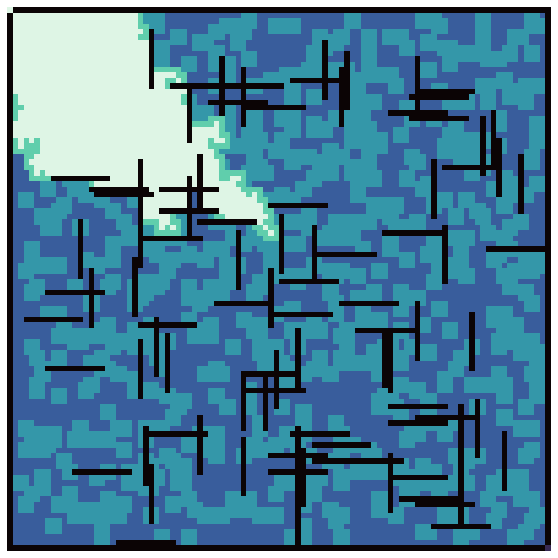

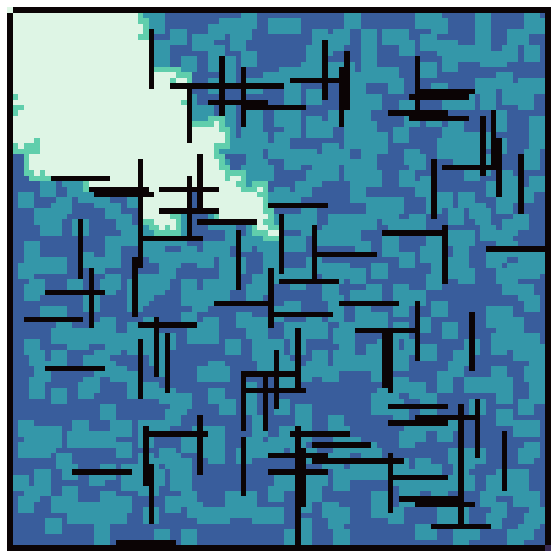

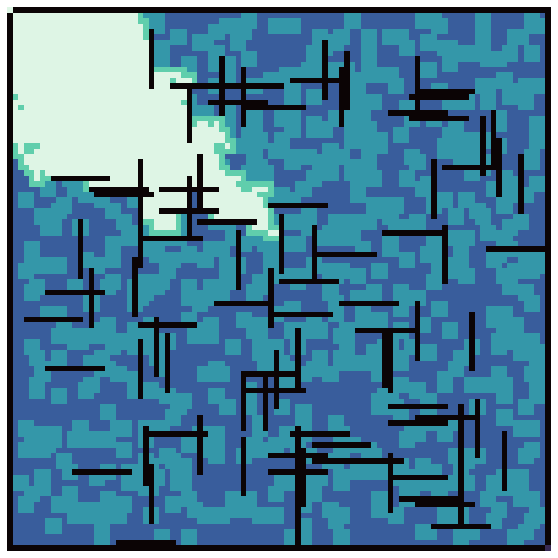

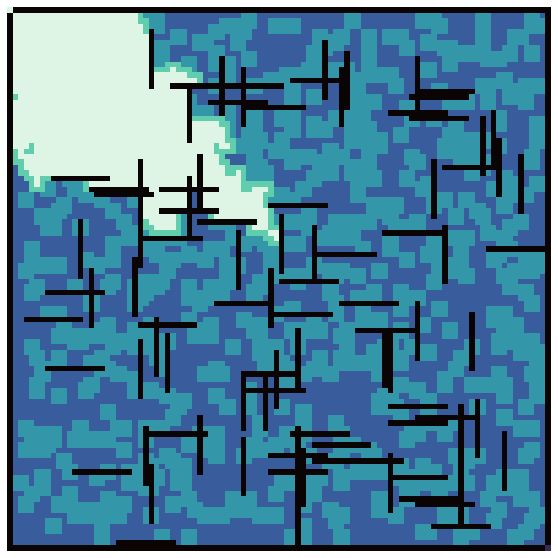

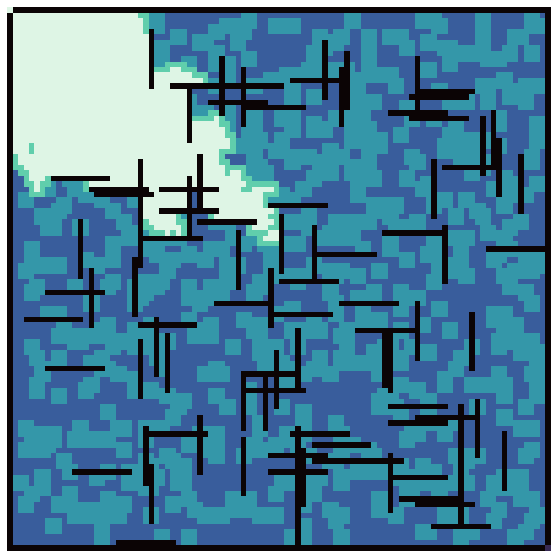

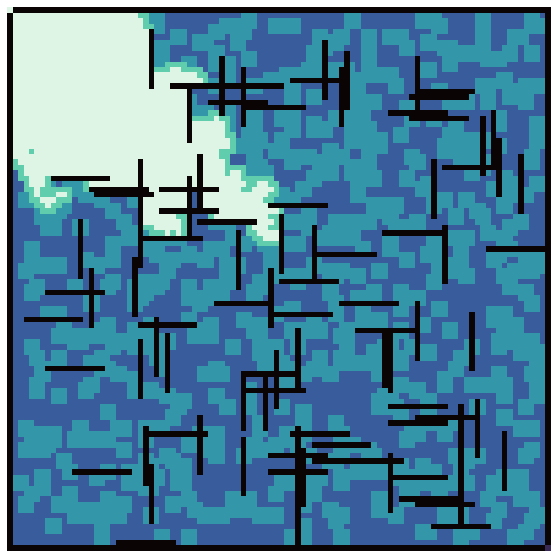

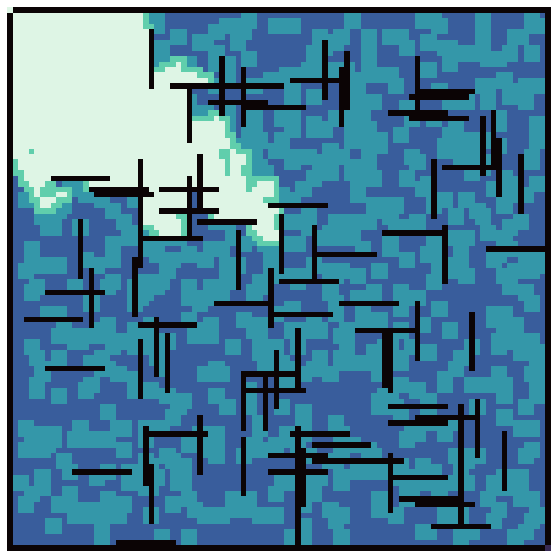

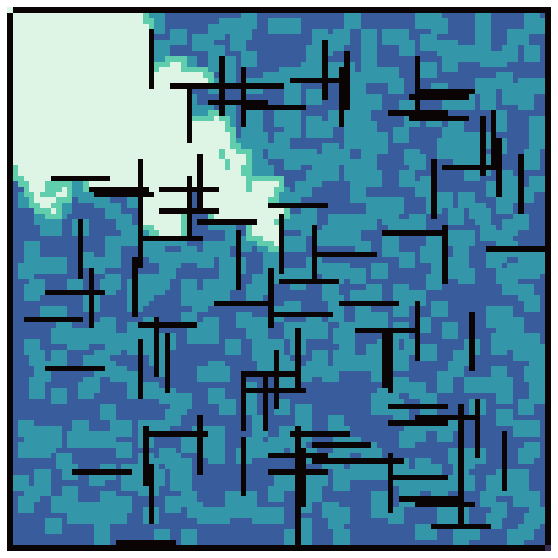

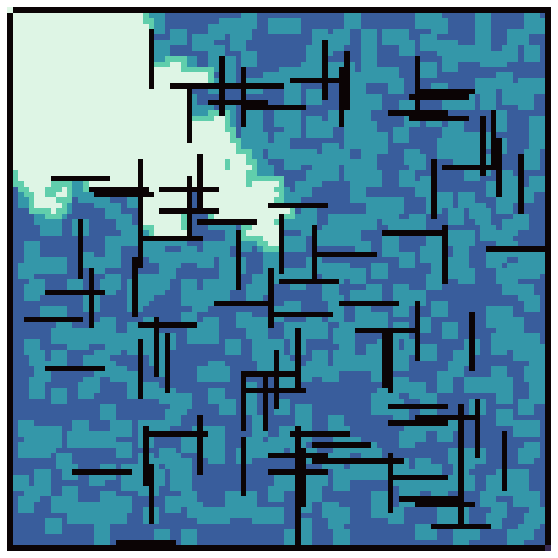

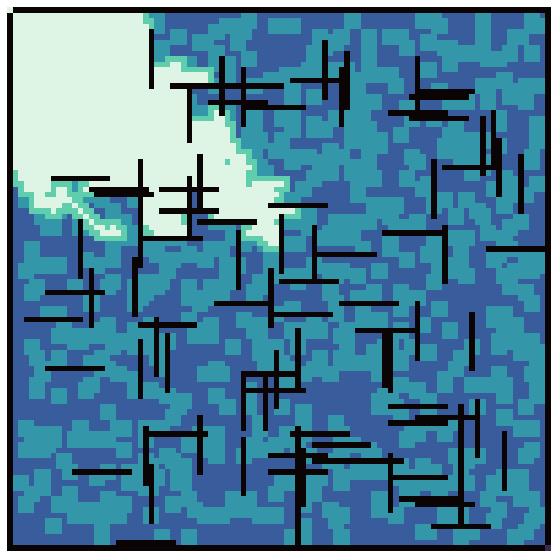

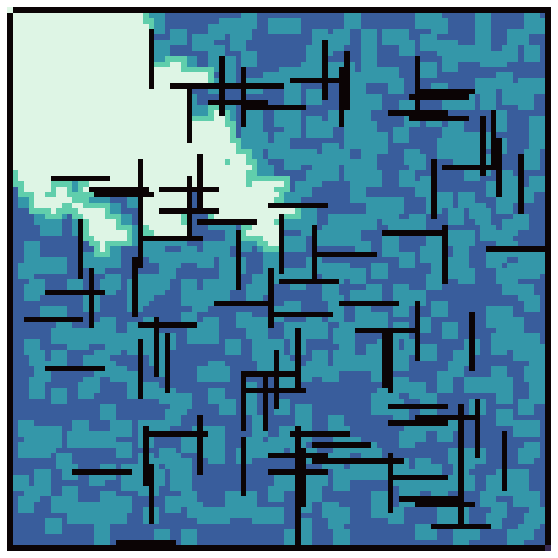

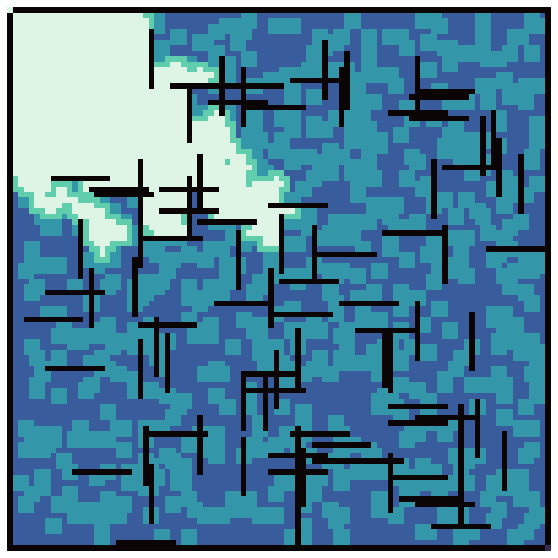

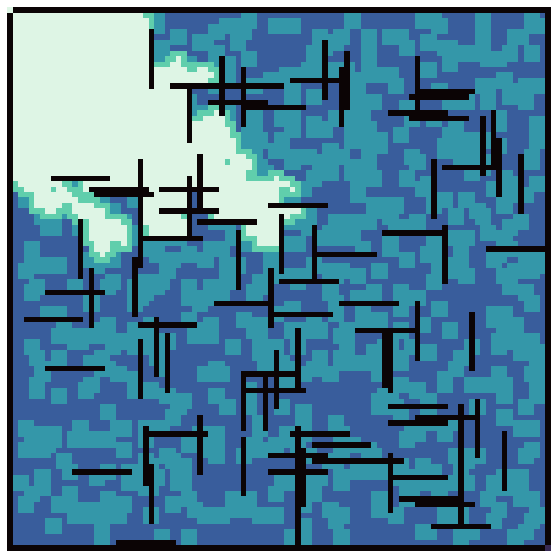

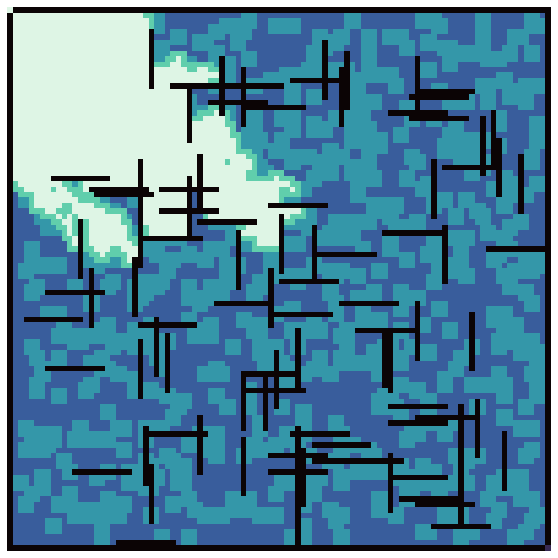

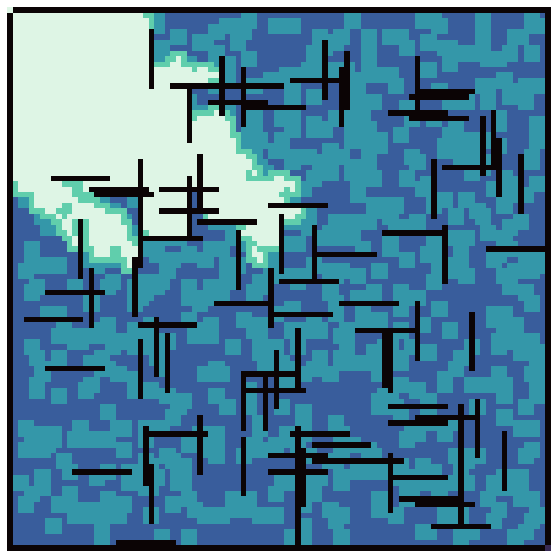

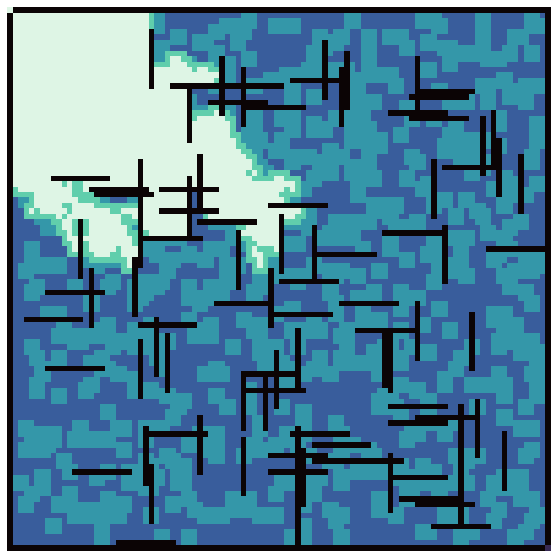

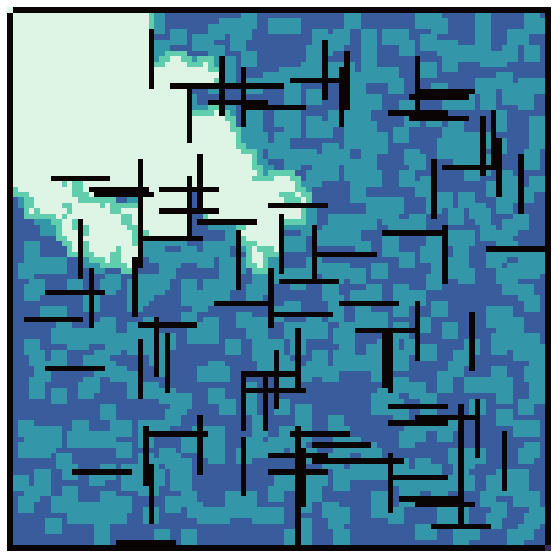

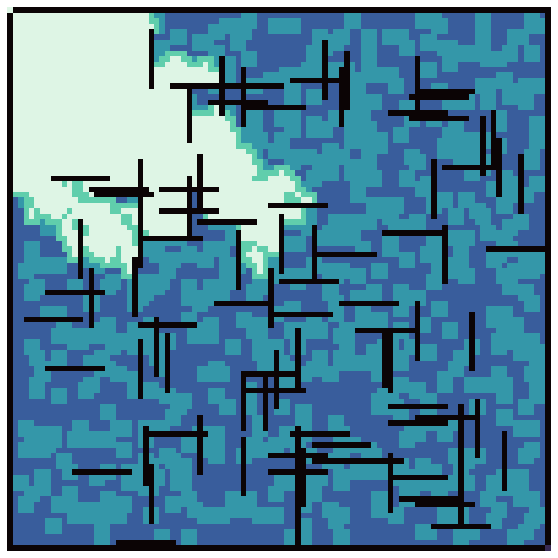

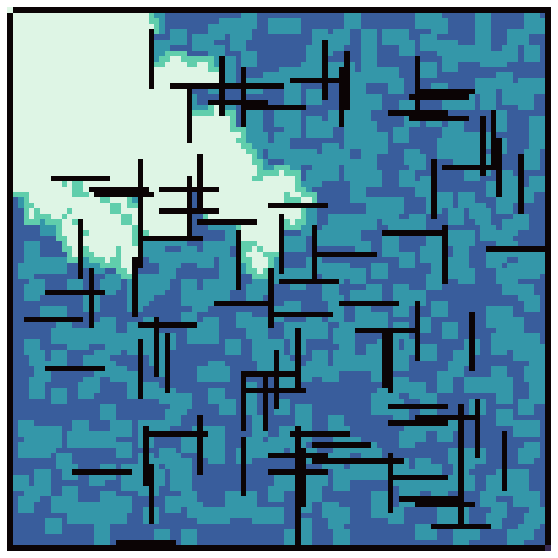

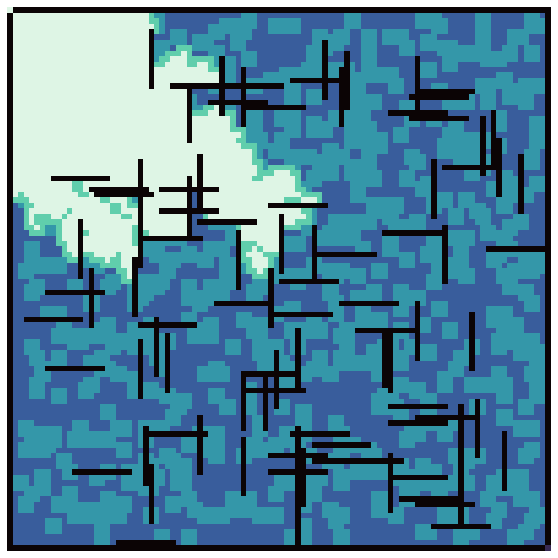

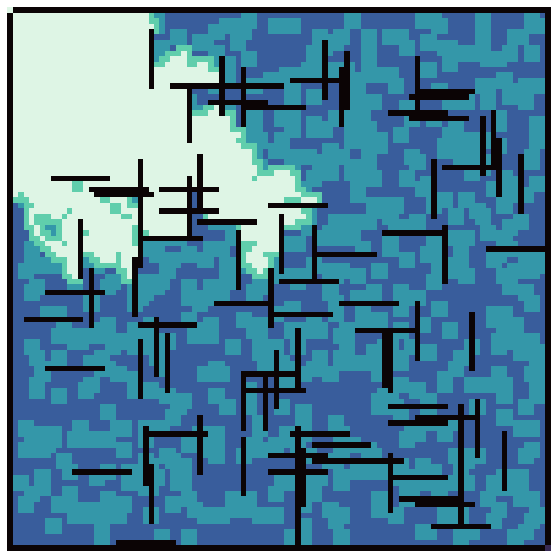

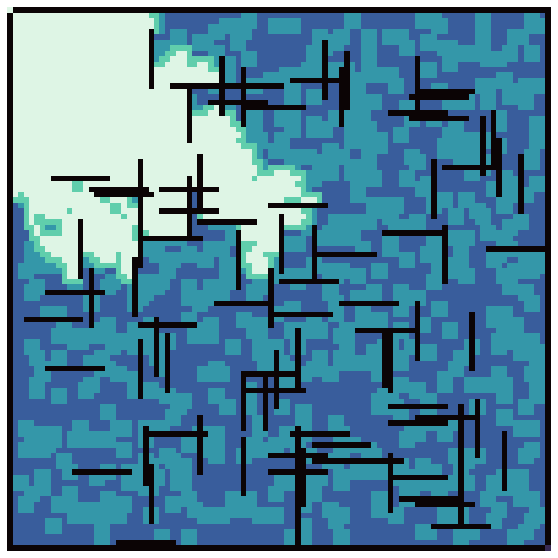

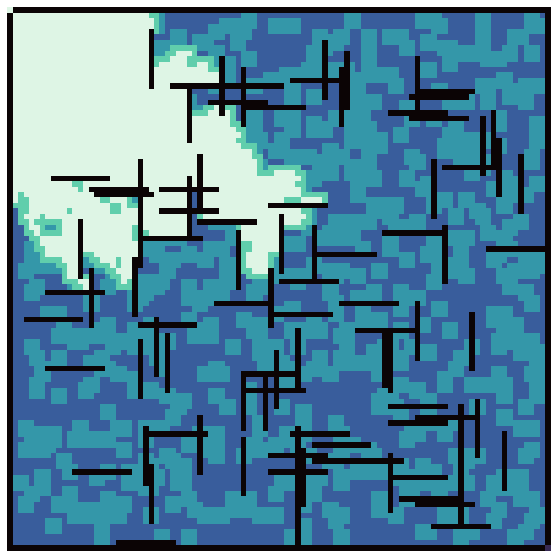

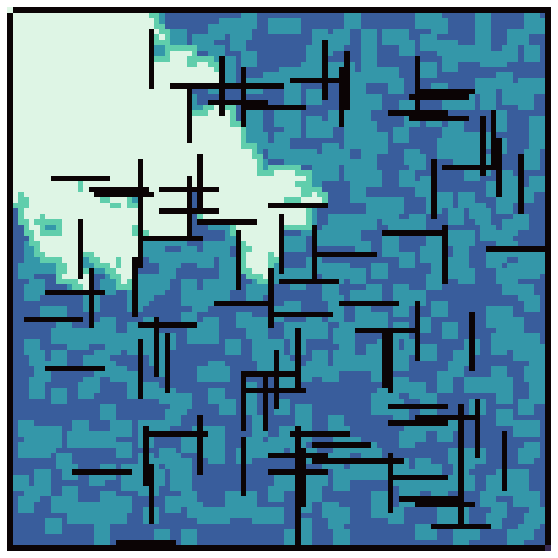

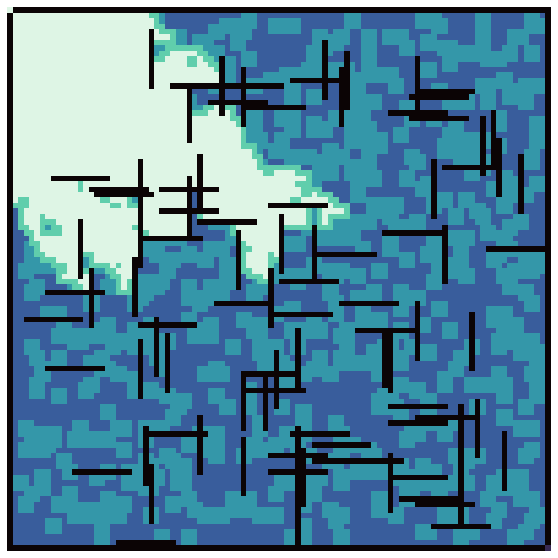

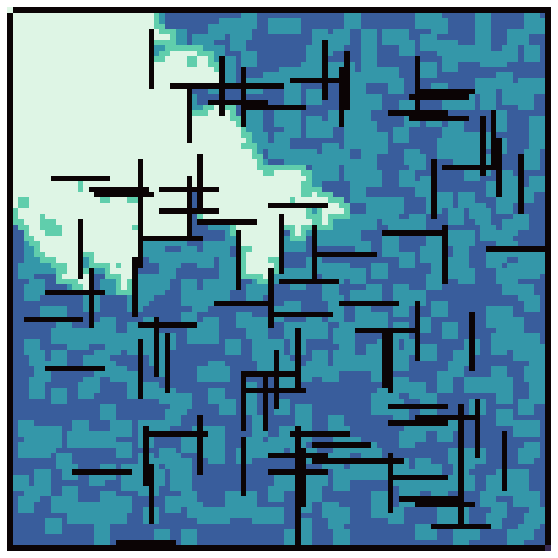

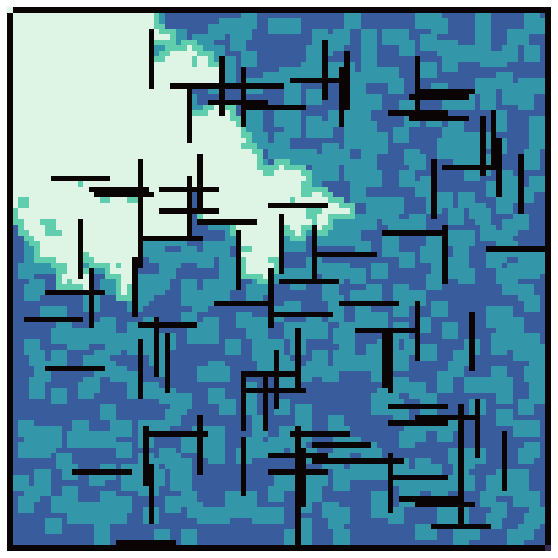

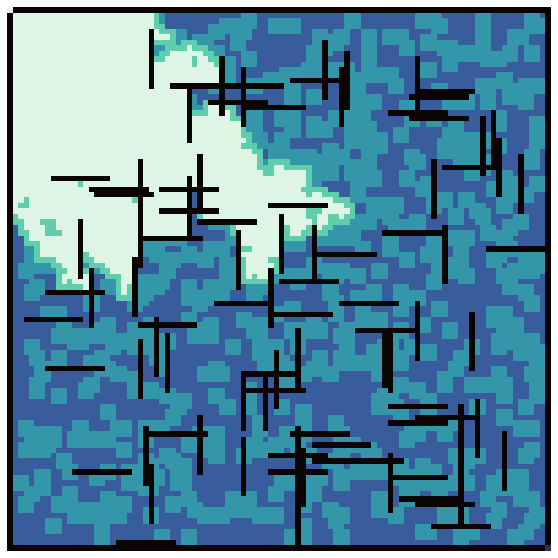

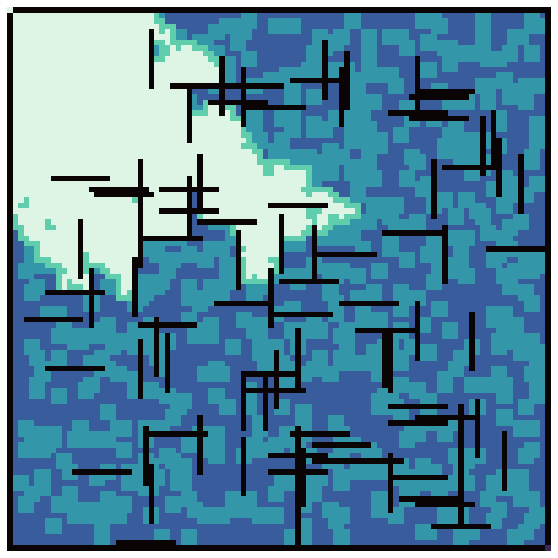

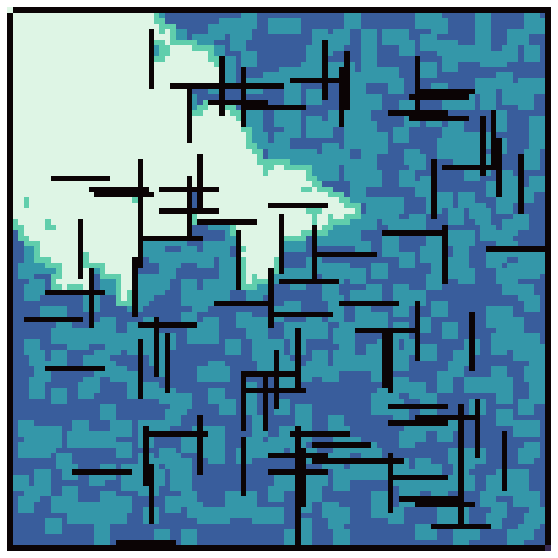

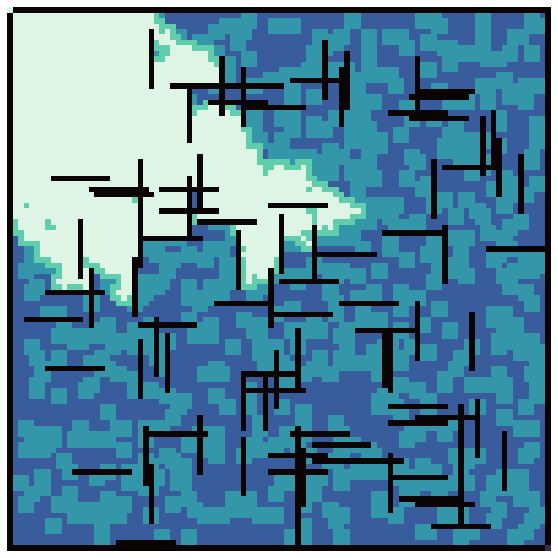

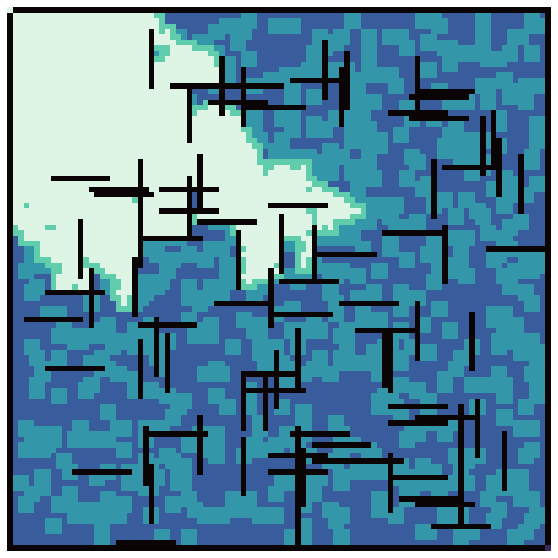

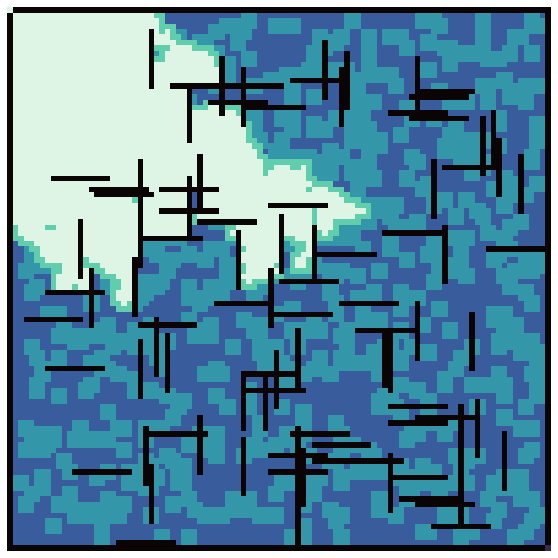

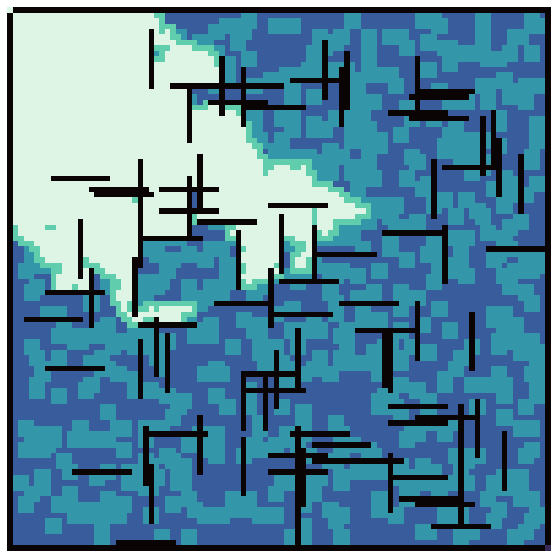

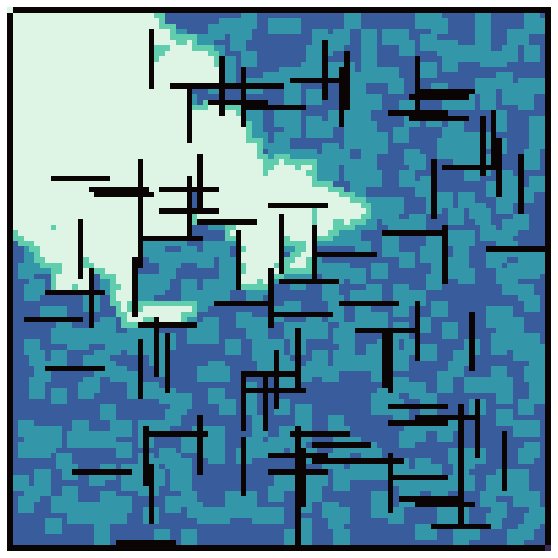

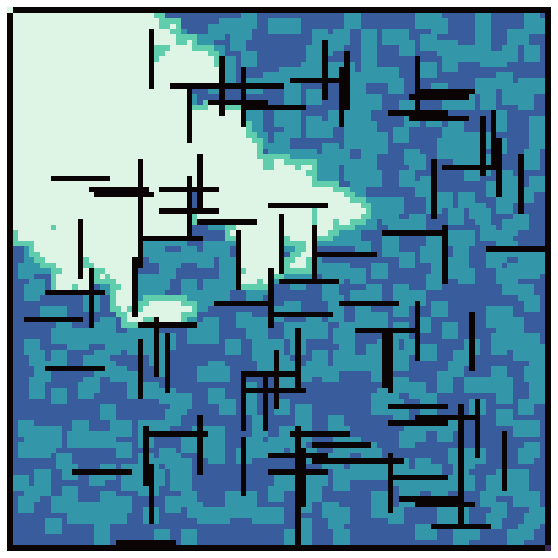

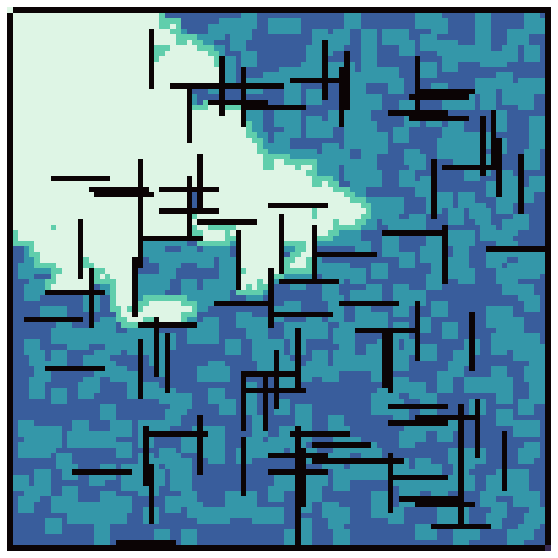

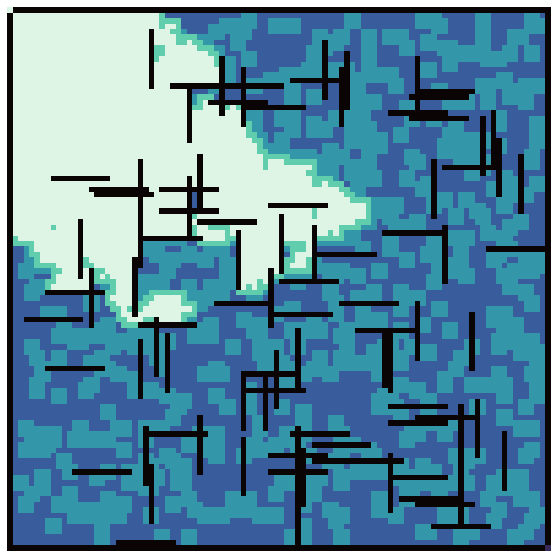

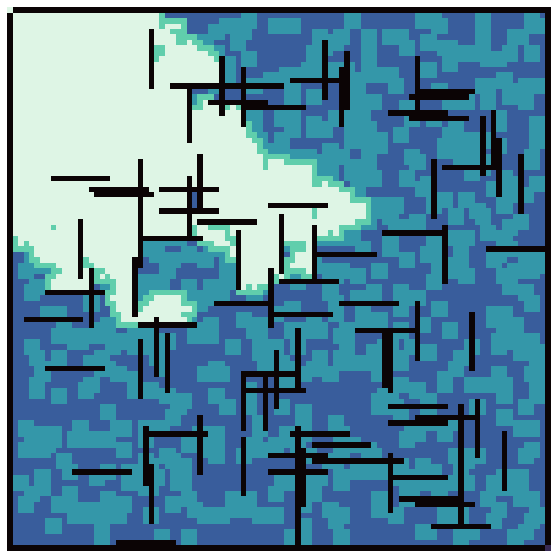

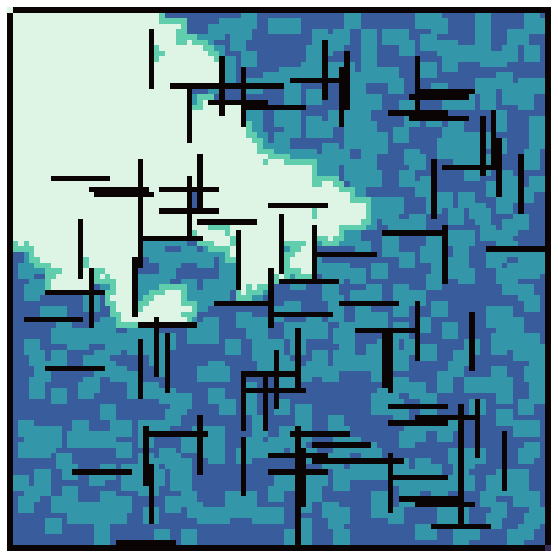

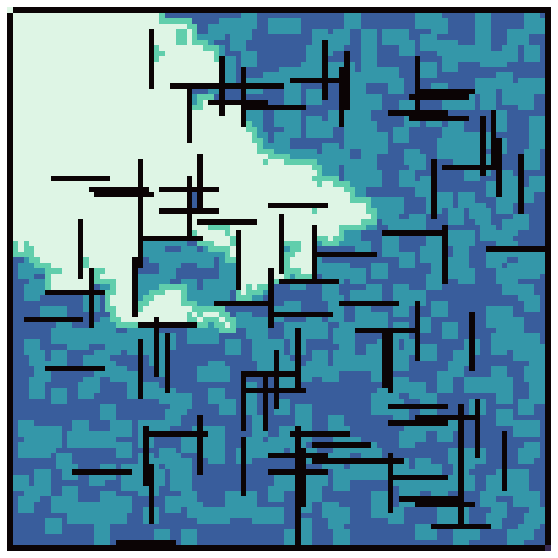

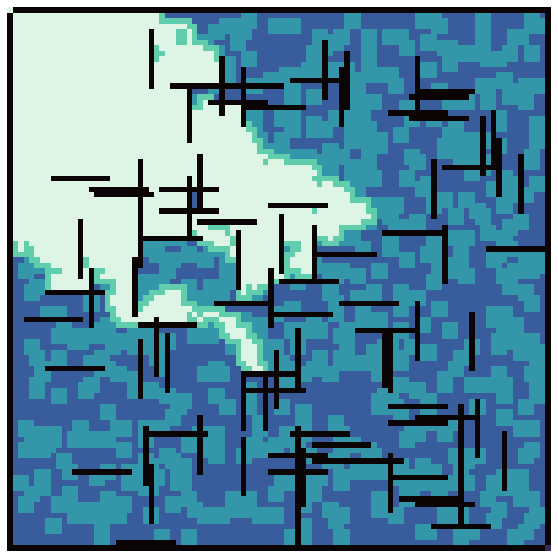

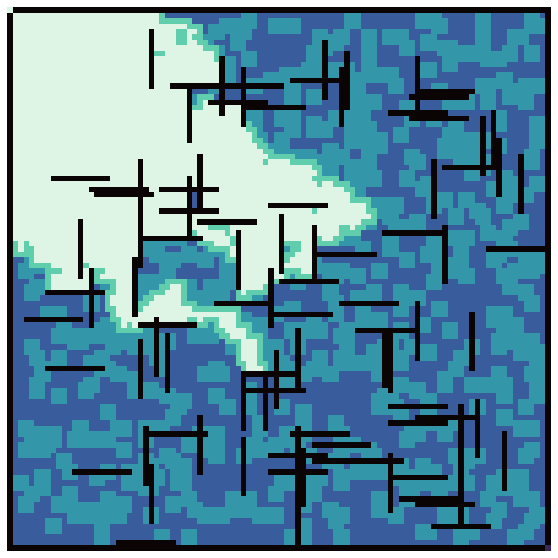

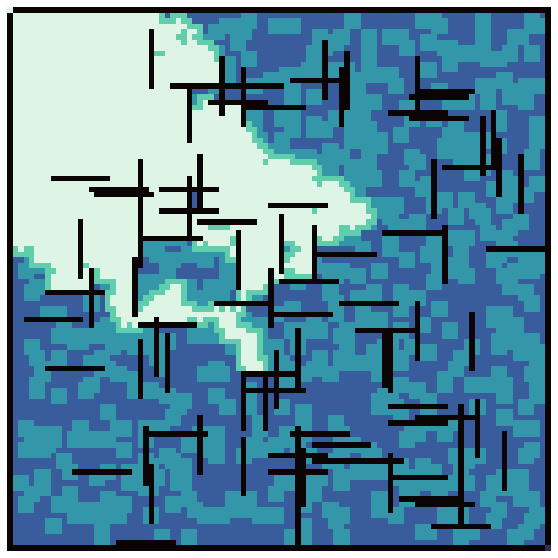

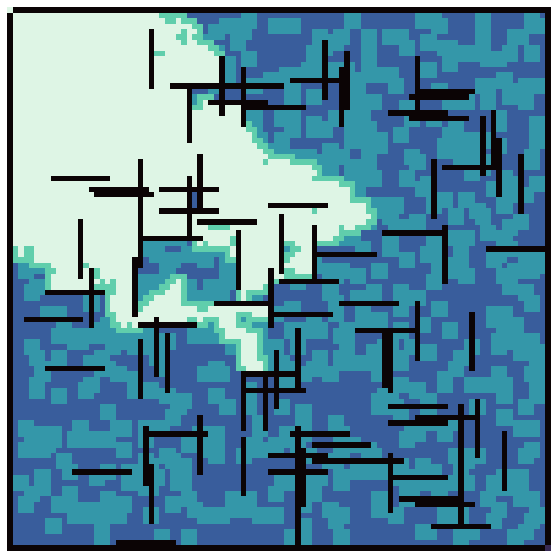

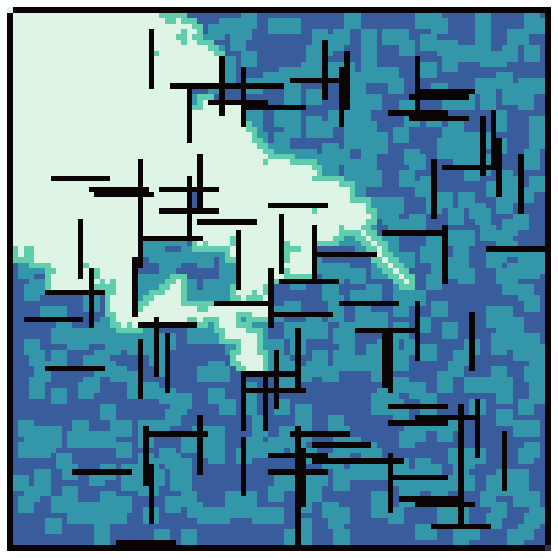

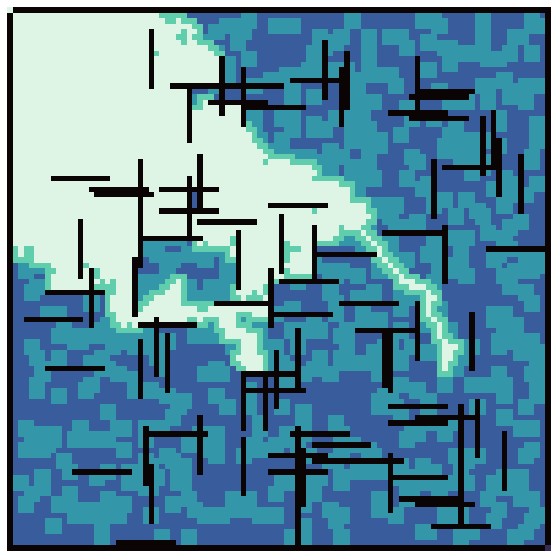

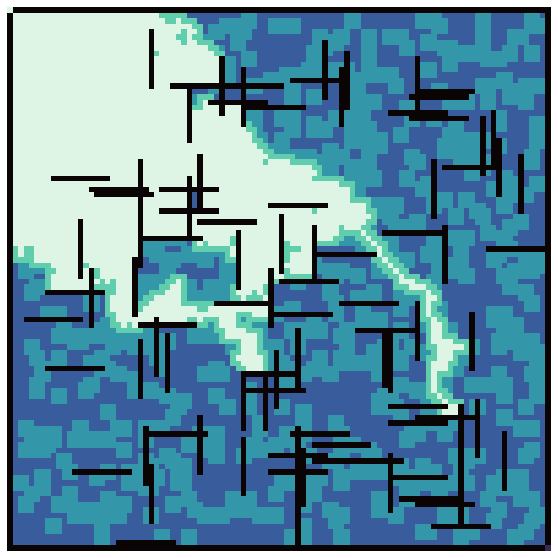

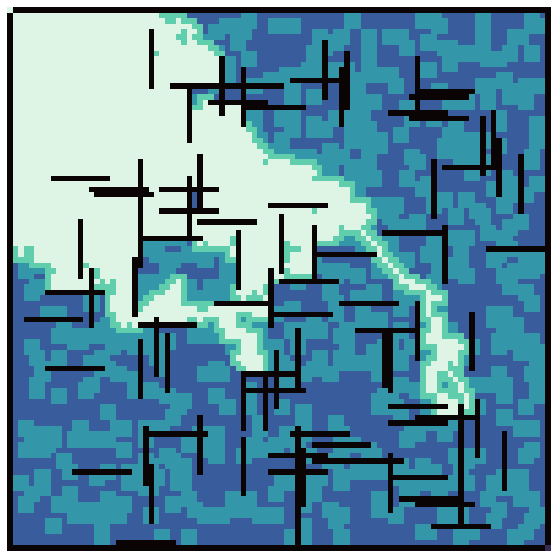

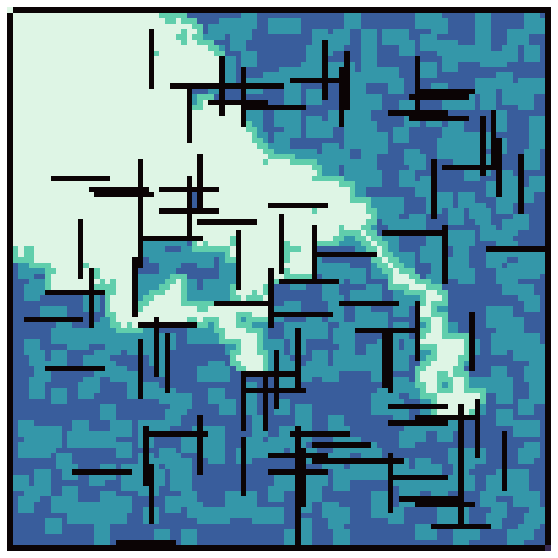

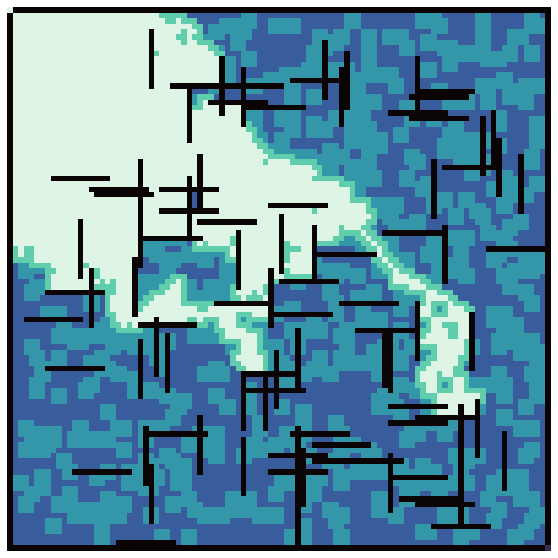

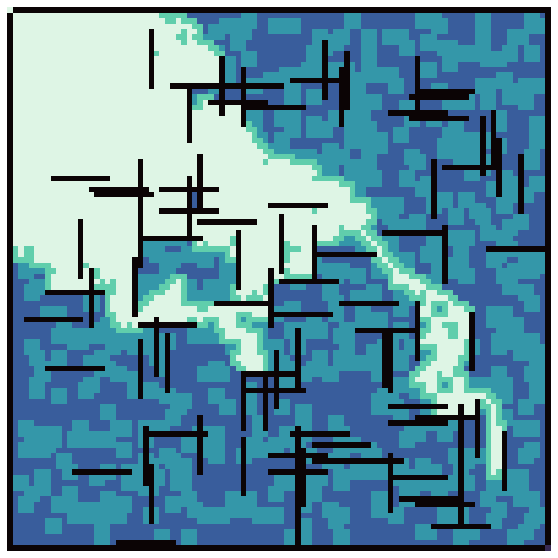

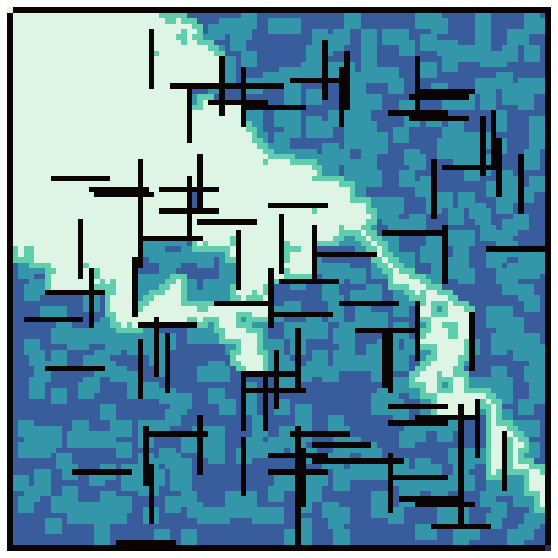

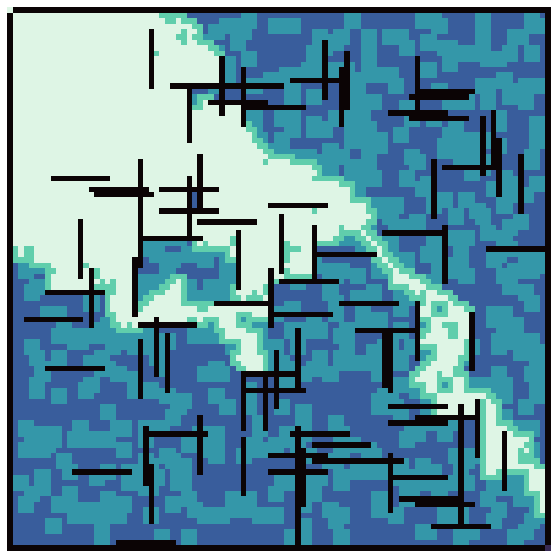

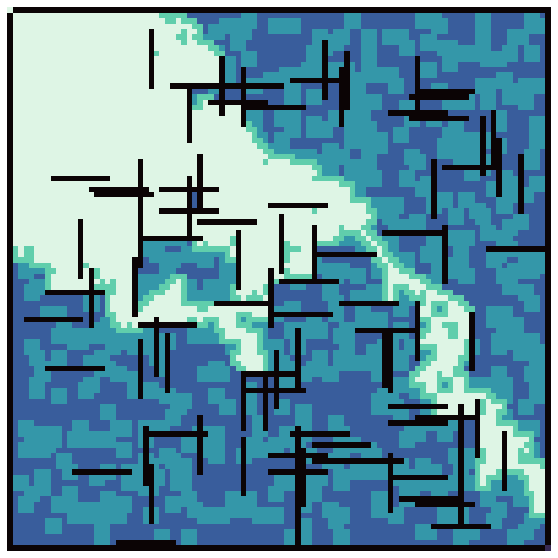

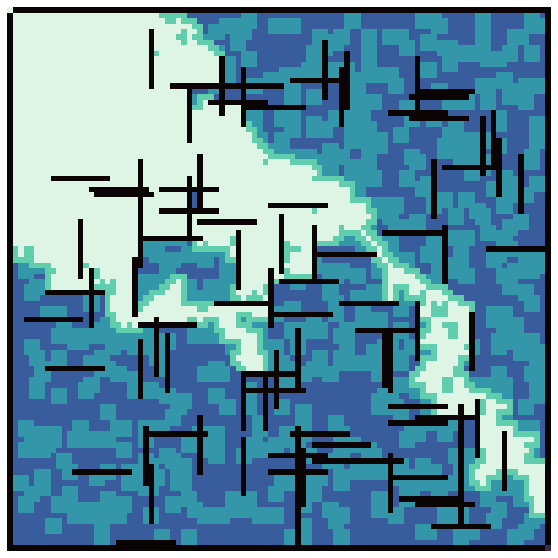

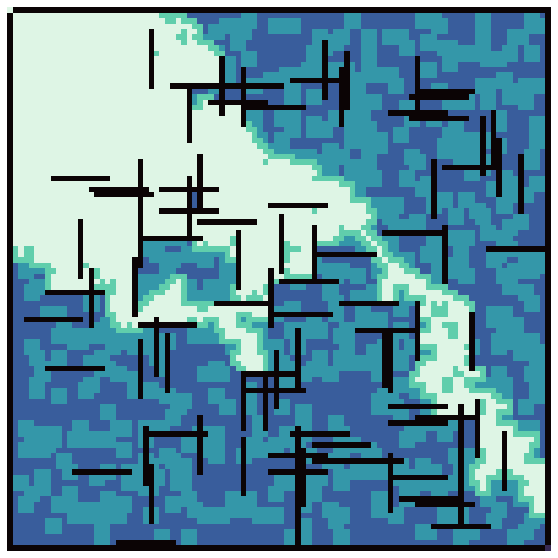

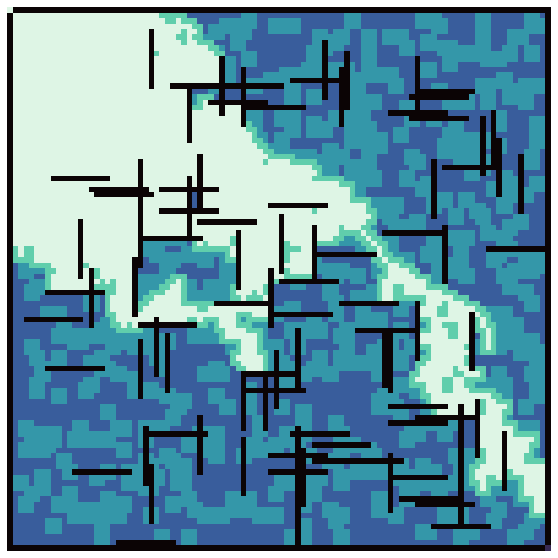

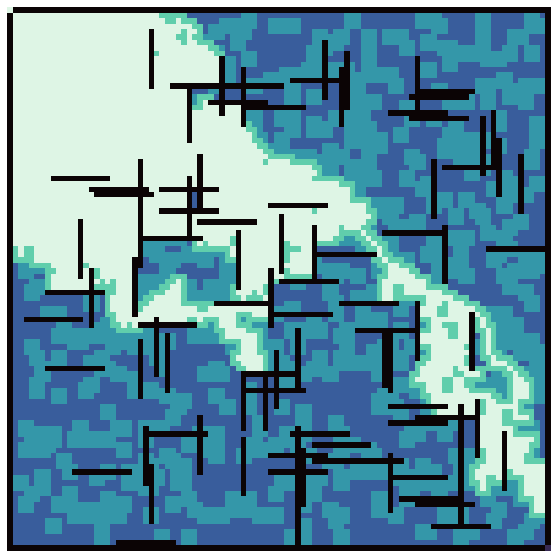

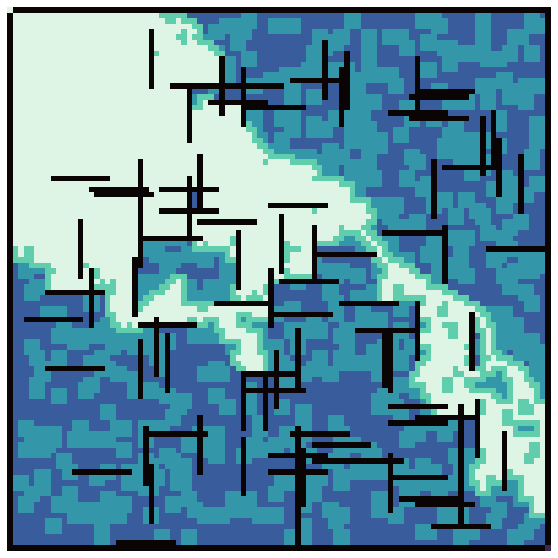

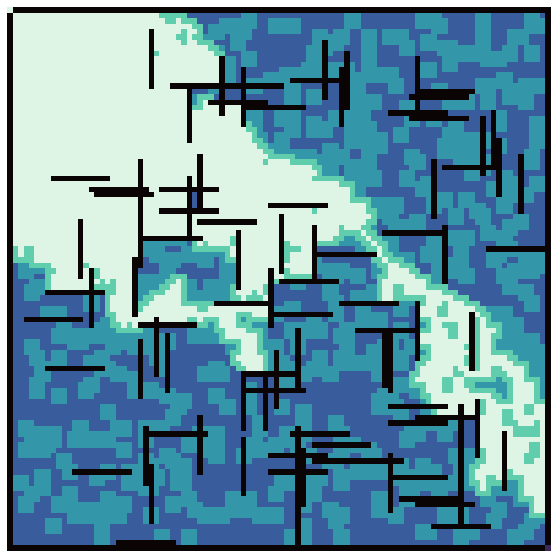

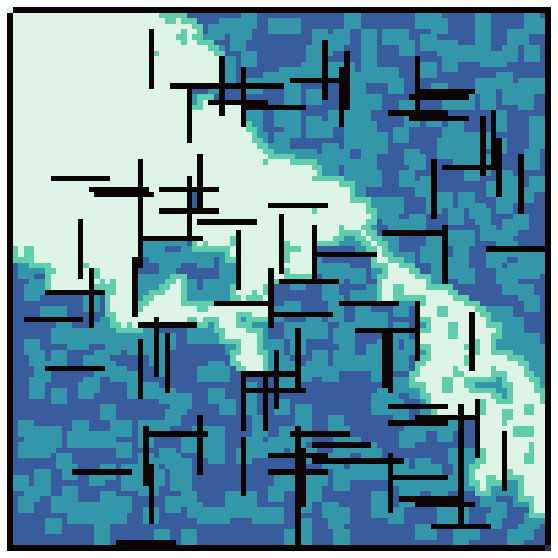

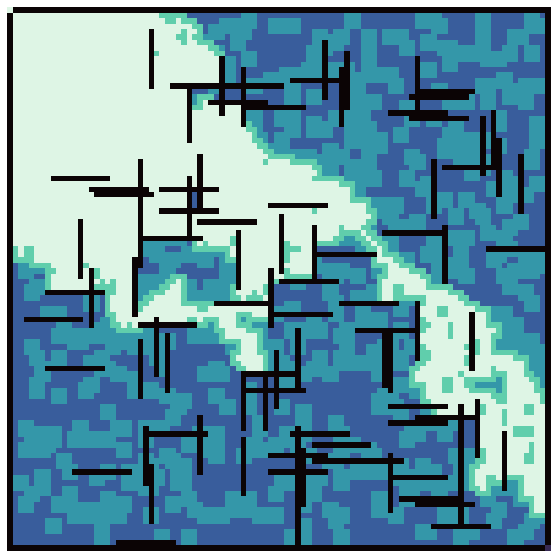

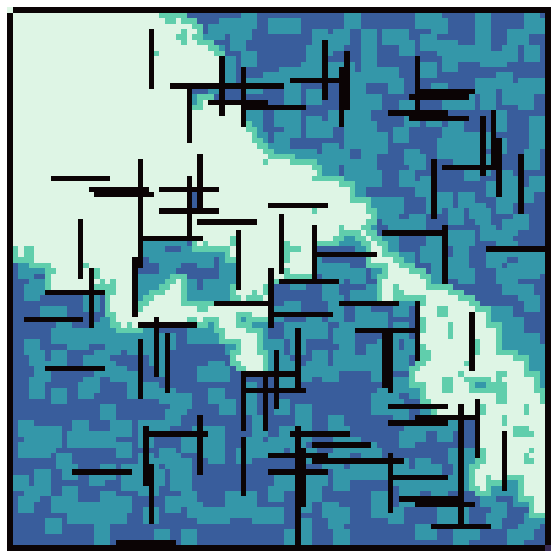

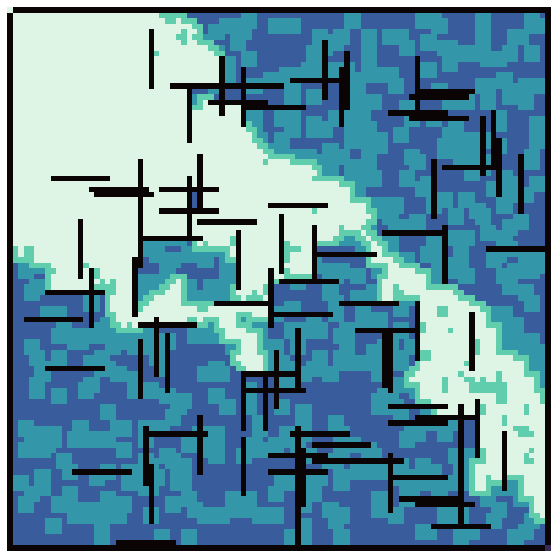

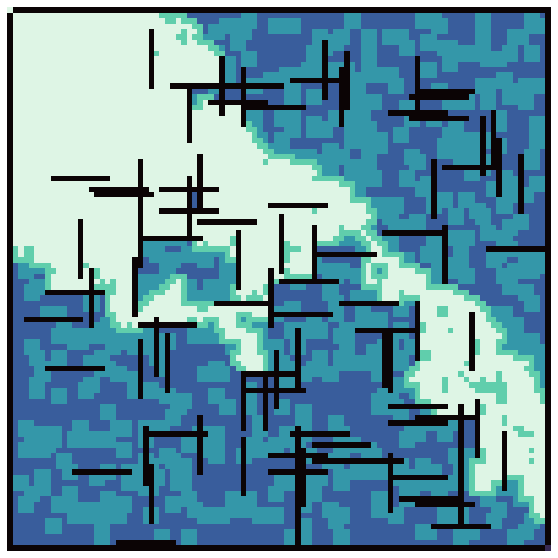

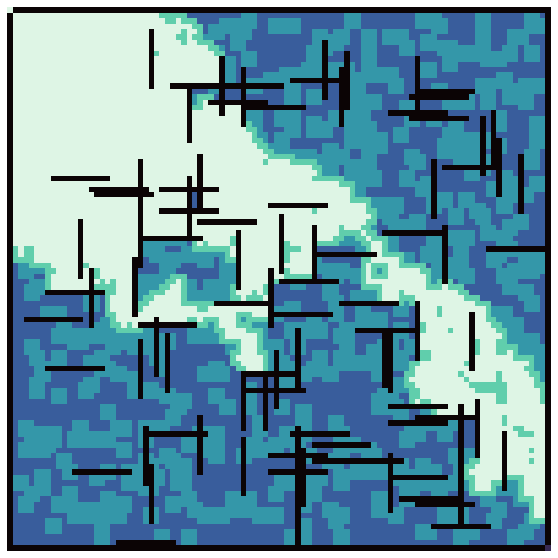

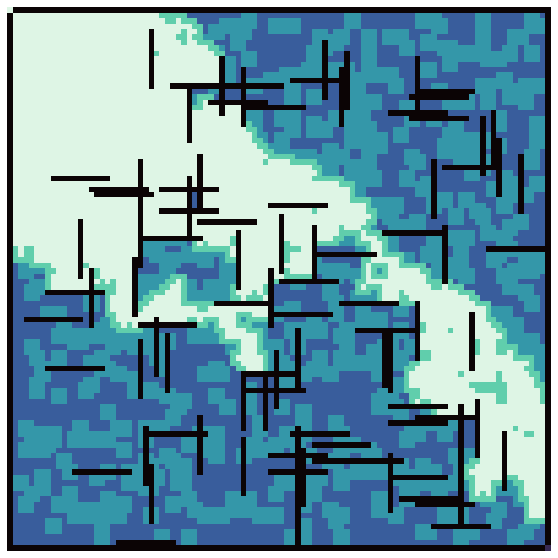

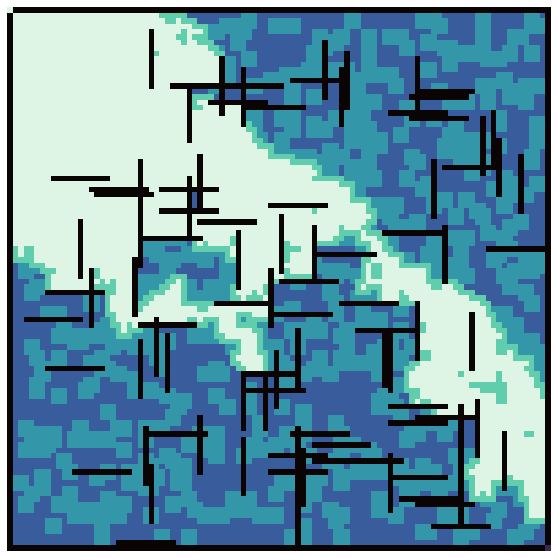

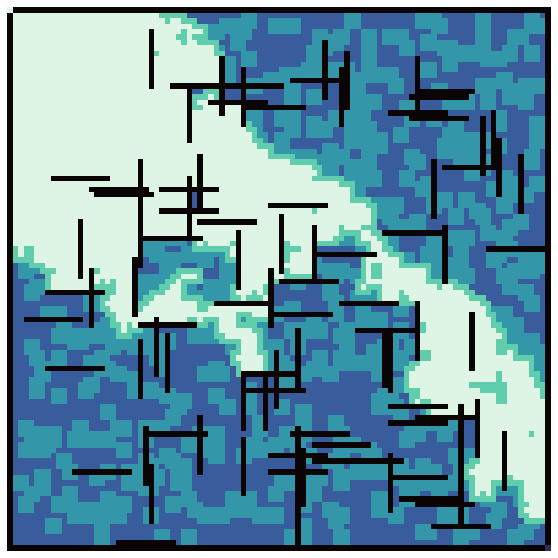

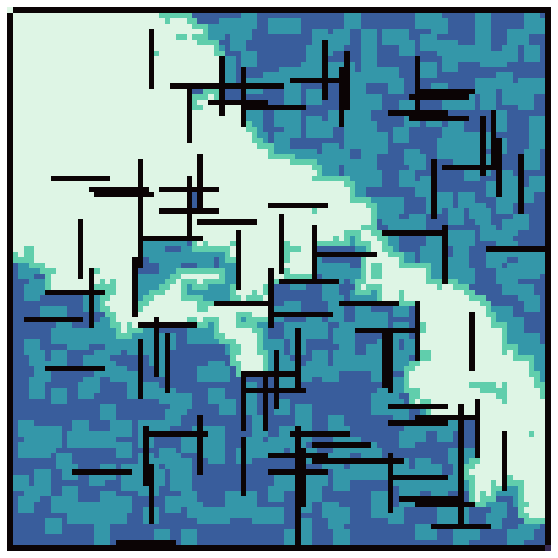

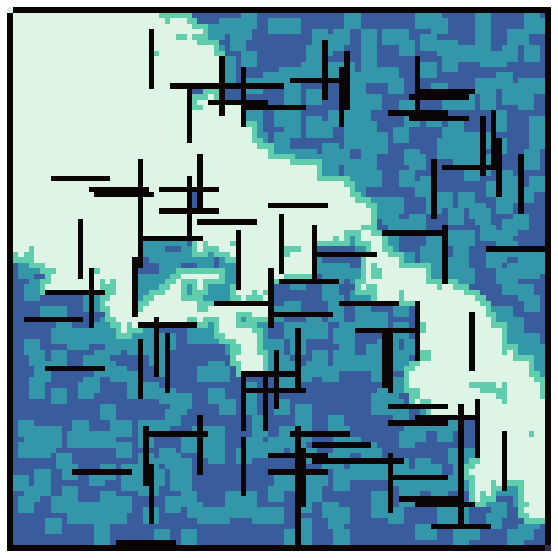

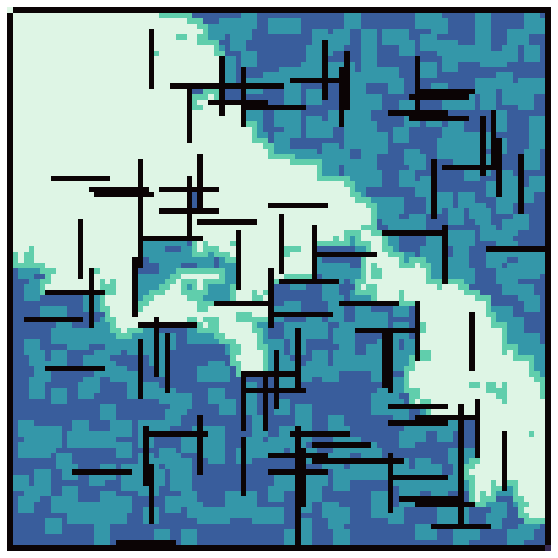

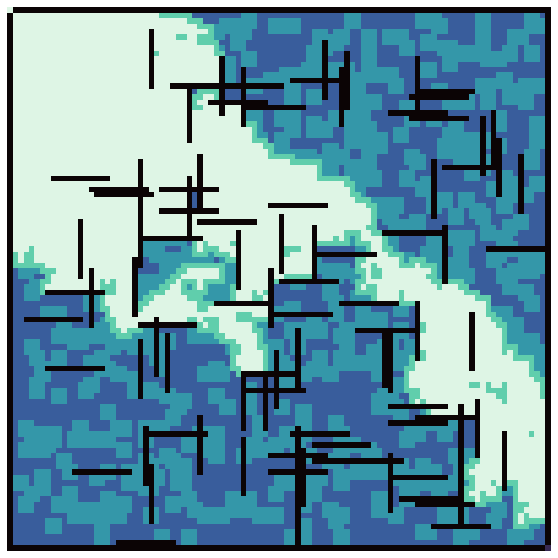

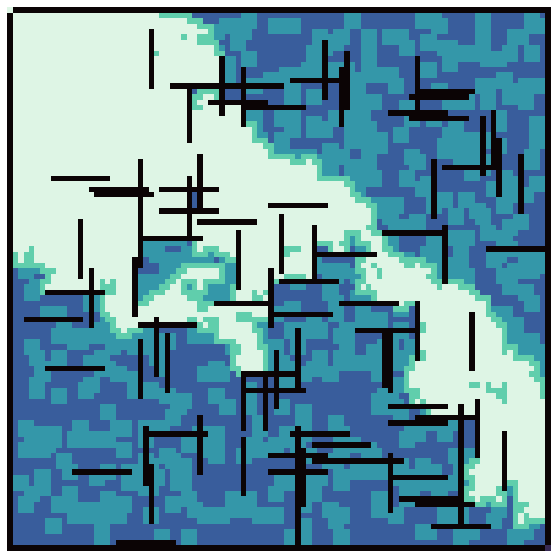

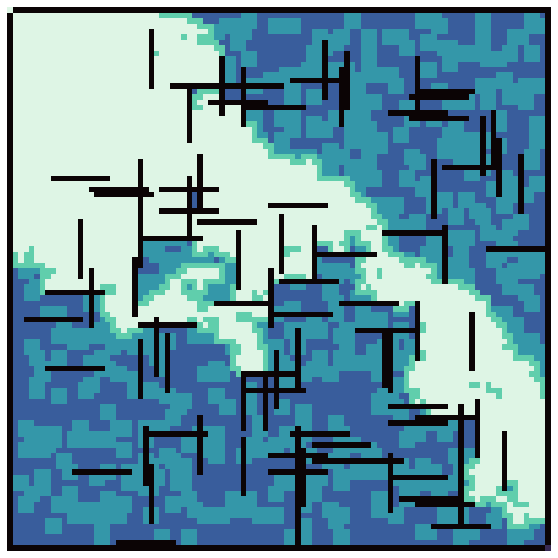

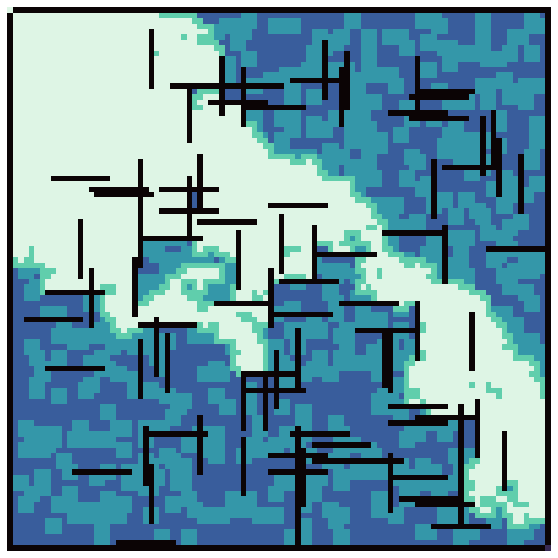

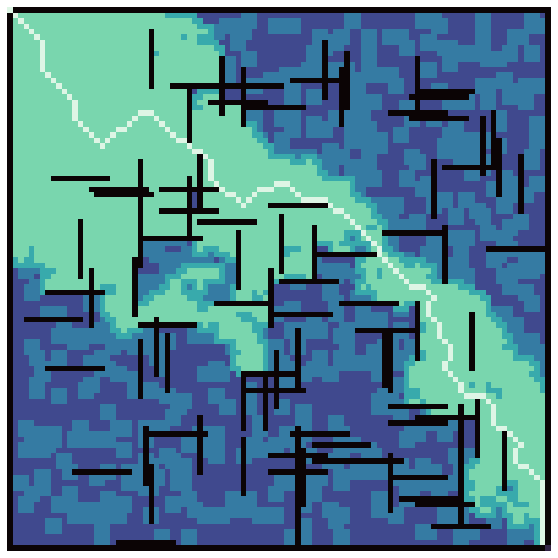

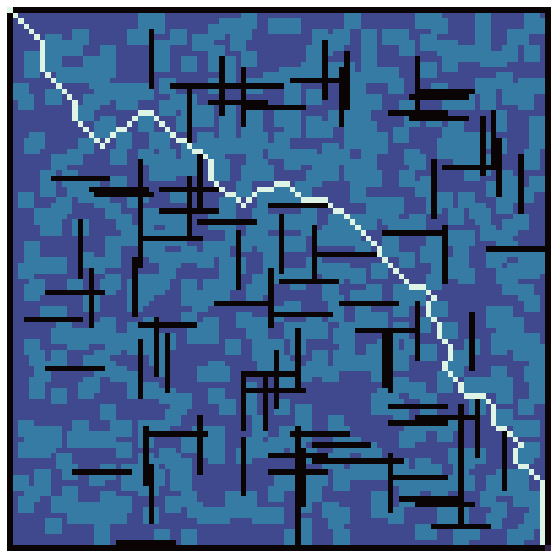

In [12]:
lines_info = list(read_file(CSV_ENV_FILE))
grid = np.array(lines_info, dtype=object)

MAP_SIZE = len(lines_info[0]) - 1
START = (0, 0)              # initial state
GOAL = (MAP_SIZE, MAP_SIZE) # goal state

counter = 0
q = [START]
node_map = {START: Node(grid[0][0], START, 0, 0, [START])}

for (y, line) in enumerate(grid):
    for (x, _) in enumerate(line):
        if (y, x) != START:
            pos = (y, x)
            heuristic = calculate_heuristic_distance_octile_sqrt(*pos, *GOAL)
            node_map[pos] = Node(grid[y][x], pos, 9999, heuristic, [])

shutil.rmtree('output')
os.makedirs('output')
a_star_algo(counter, q, node_map, GOAL)
create_gif()